# Stock Price Forecasting using ARIMA

+ The models were tested on 6 financial markets: Amazon, CAC, IBM, Microsoft, Nasdaq, and S&P 500.
+ Data was given by Euklid LTD for the time window of March 1994 to March 2024.

# Importing Libraries

In [60]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
import scipy.interpolate as sci
import scipy.optimize as sco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from math import ceil

# Loading data

In [61]:
amazon = pd.read_csv('/content/Amazon_weekly.csv')
cac = pd.read_csv('/content/Cac_weekly.csv')
ibm = pd.read_csv('/content/IBM_weekly.csv')
microsoft = pd.read_csv('/content/Microsoft_weekly.csv')
nasdaq = pd.read_csv('/content/Nasdaq_weekly.csv')
sp500 = pd.read_csv('/content/Sp500_weekly.csv')

In [62]:
# list of DataFrames (dfs)
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

for df in dfs:
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Preprocessing data

In [63]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

# list of names
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"{name}: {df.shape}")

amazon: (1399, 6)
cac: (1566, 6)
ibm: (1566, 6)
microsoft: (1566, 6)
nasdaq: (1566, 6)
sp500: (1566, 6)


In [64]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

null_dfs = []

for df, name in zip(dfs, names):
  null_count_df = pd.DataFrame(df.isnull().sum(), columns=[name])
  null_dfs.append(null_count_df)

# concatenate dfs horizontally
result_df = pd.concat(null_dfs, axis=1)

print(result_df)

        amazon  cac  ibm  microsoft  nasdaq  sp500
Date         0    0    0          0       0      0
Open         0    2    0          0       2      2
High         0    2    0          0       2      2
Low          0    2    0          0       2      2
Close        0    2    0          0       2      2
Volume       0    0    0          0       0      0


In [65]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
    df.dropna(inplace=True)

In [66]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

null_dfs = []

for df, name in zip(dfs, names):
  null_count_df = pd.DataFrame(df.isnull().sum(), columns=[name])
  null_dfs.append(null_count_df)

# concatenate dfs horizontally
result_df = pd.concat(null_dfs, axis=1)

print(result_df)

        amazon  cac  ibm  microsoft  nasdaq  sp500
Date         0    0    0          0       0      0
Open         0    0    0          0       0      0
High         0    0    0          0       0      0
Low          0    0    0          0       0      0
Close        0    0    0          0       0      0
Volume       0    0    0          0       0      0


In [67]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  duplicates = df.duplicated()
  num_duplicates = duplicates.sum()
  print(f"Duplicated rows in {name}: {num_duplicates}")

Duplicated rows in amazon: 0
Duplicated rows in cac: 0
Duplicated rows in ibm: 0
Duplicated rows in microsoft: 0
Duplicated rows in nasdaq: 0
Duplicated rows in sp500: 0


In [68]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"Data types of columns in {name} dataset:")
  print(df.dtypes)

Data types of columns in amazon dataset:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
Data types of columns in cac dataset:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object
Data types of columns in ibm dataset:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
Data types of columns in microsoft dataset:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
Data types of columns in nasdaq dataset:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           

In [69]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

# list of names
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"{name}: {df.shape}")

amazon: (1399, 6)
cac: (1564, 6)
ibm: (1566, 6)
microsoft: (1566, 6)
nasdaq: (1564, 6)
sp500: (1564, 6)


# EDA

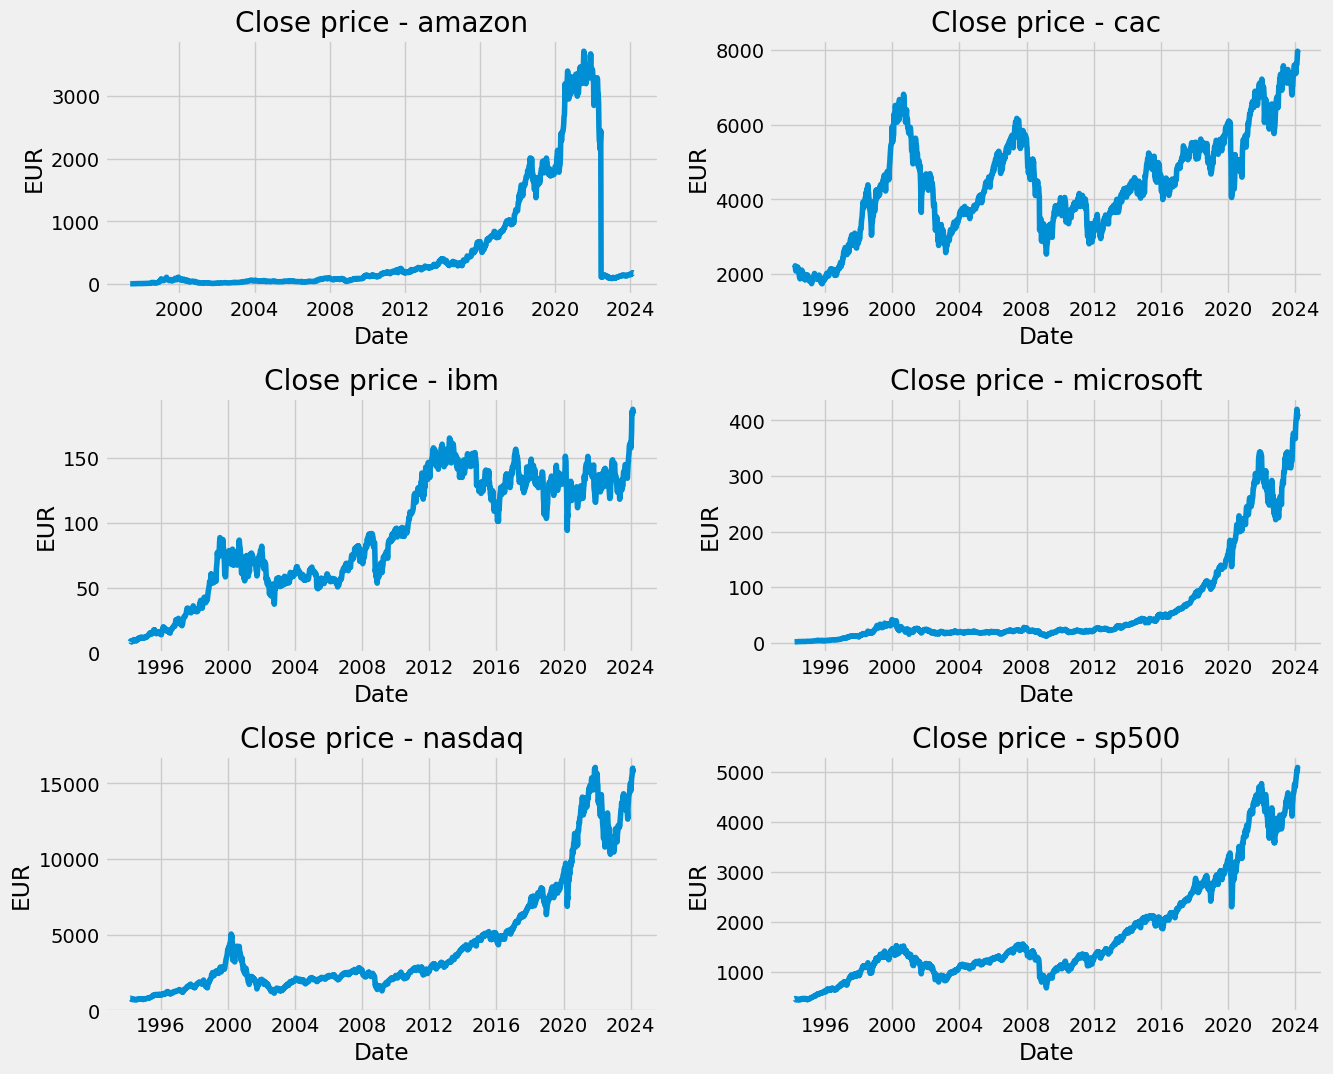

In [70]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for df, name, ax in zip(dfs, names, axes.flatten()):
  df['Date'] = pd.to_datetime(df['Date'])
  sns.lineplot(data=df, x='Date', y='Close', ax=ax)
  ax.set_title(f'Close price - {name}')
  ax.set_xlabel('Date')
  ax.set_ylabel('EUR')
  ax.grid(True)
  # setting x-axis date format to display years
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# Stationary data check

For ARIMA, we need to check for the Stationarity of data.

In [71]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  result = adfuller(df['Close'])
  results_list.append({'Name': name, 'ADF Statistic': result[0], 'p-value': result[1]})

# converting list of dictionaries to df
adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic  p-value
   Amazon      -2.203649 0.204924
      CAC      -1.423293 0.571059
      IBM      -1.031451 0.741621
Microsoft       3.880300 1.000000
   NASDAQ       1.524967 0.997614
    SP500       1.740065 0.998222


First,
+ about ADF, all the values should be negative and further than 0, if they are positive and close 0, it means data is not stationary.
+ looking at p-value, is bigger than the critical point >0.05 in all the dfs, which means the data in dfs is not stationary.

So, we need to make it stationary before applying ARIMA.


### Seasonal decomposition

Seasonal decomposition is an important step in time series analysis. It decomposes time series to the components like: trend, seasonality, and noise (or residual).

In [72]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

df = pd.concat([df.set_index('Date')['Close'] for df in dfs], axis=1, join='outer', keys=['AMAZON', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500'])
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df.index.name = 'Date'

df.head()

,AMAZON,CAC,IBM,Microsoft,NASDAQ,SP500
Date,,,,,,
1994-03-06,NaN,2178.69,8.0537,1.8029,790.55,464.74
1994-03-13,NaN,2174.91,8.5512,1.8194,789.20,466.44
1994-03-20,NaN,2221.34,8.7424,1.8860,803.93,471.06
1994-03-27,NaN,2136.62,8.2642,1.9473,783.45,460.58
1994-04-03,NaN,2081.94,8.3599,1.8860,743.46,445.77


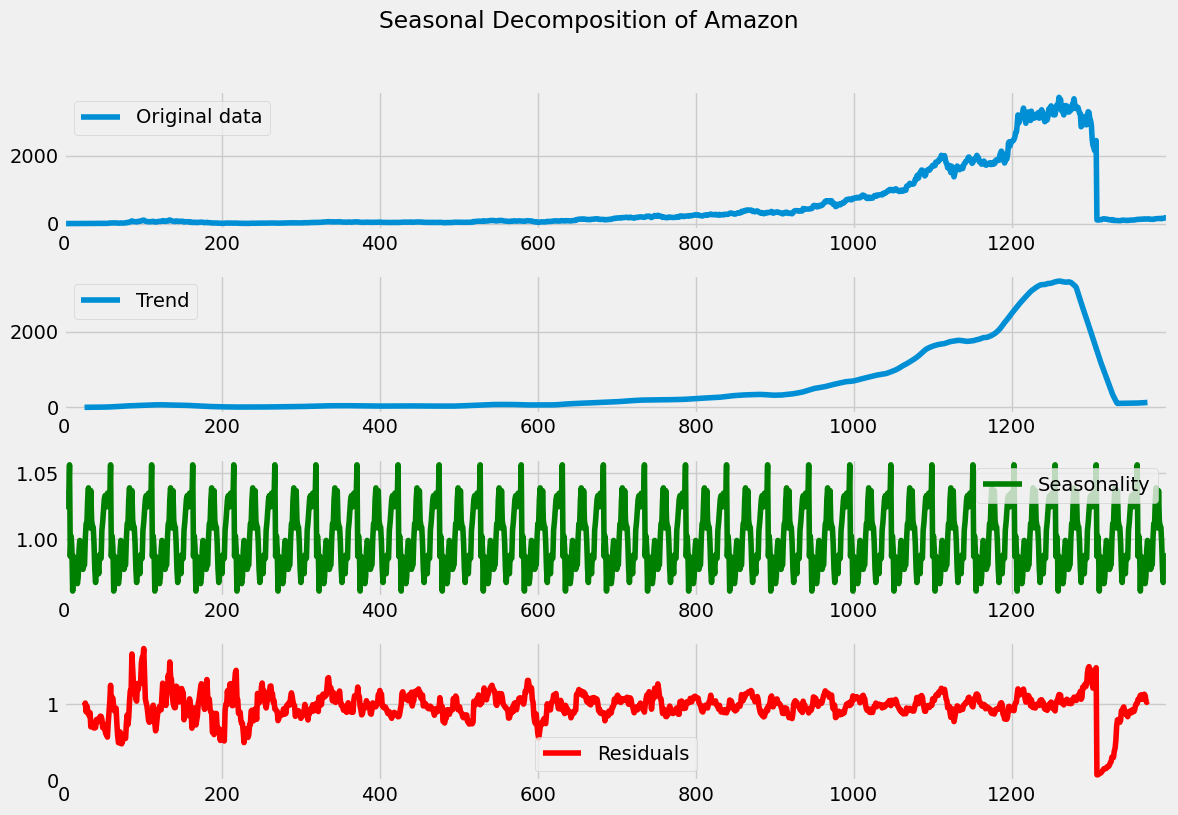

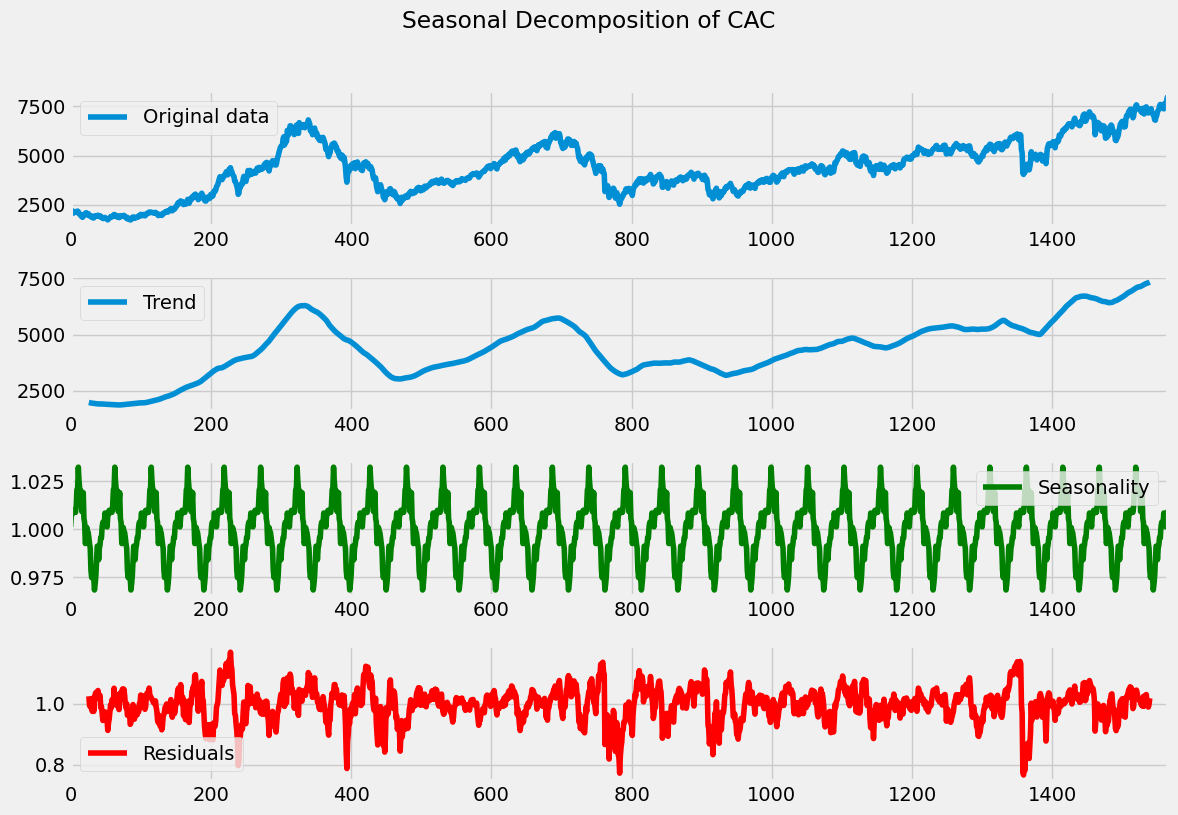

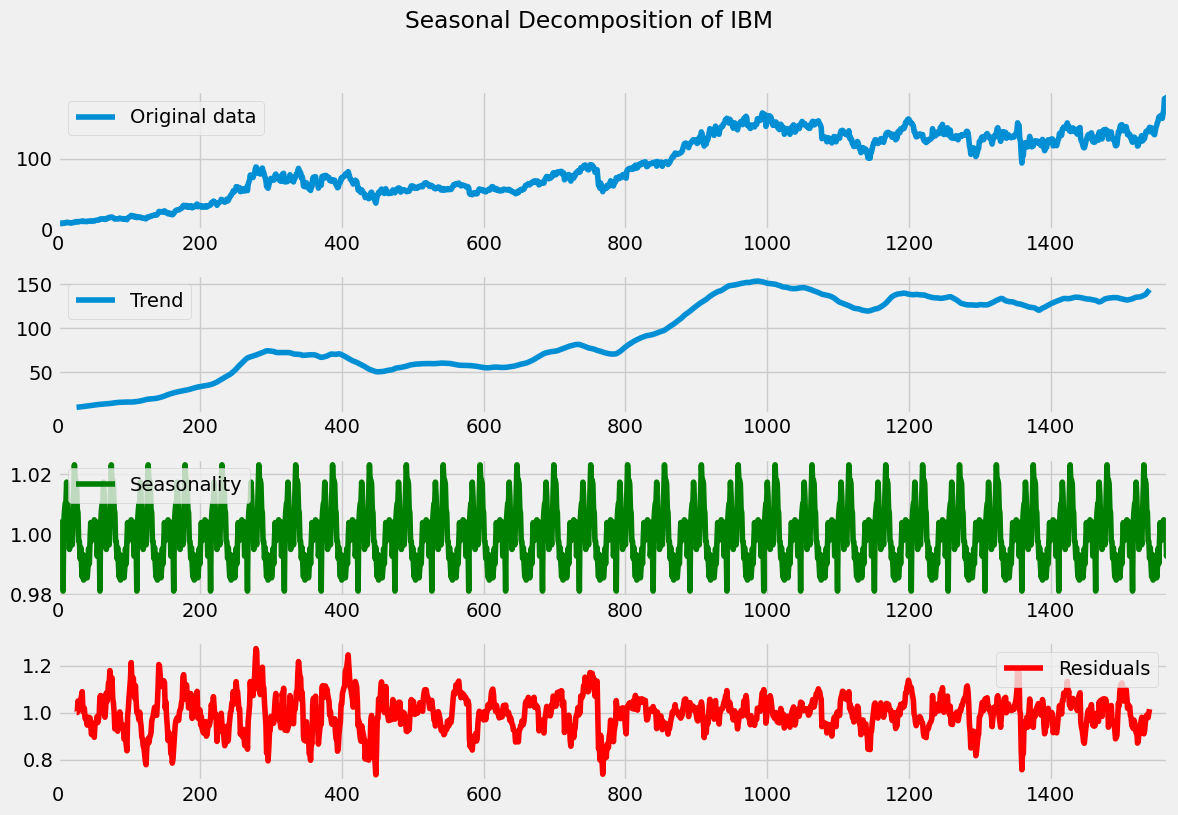

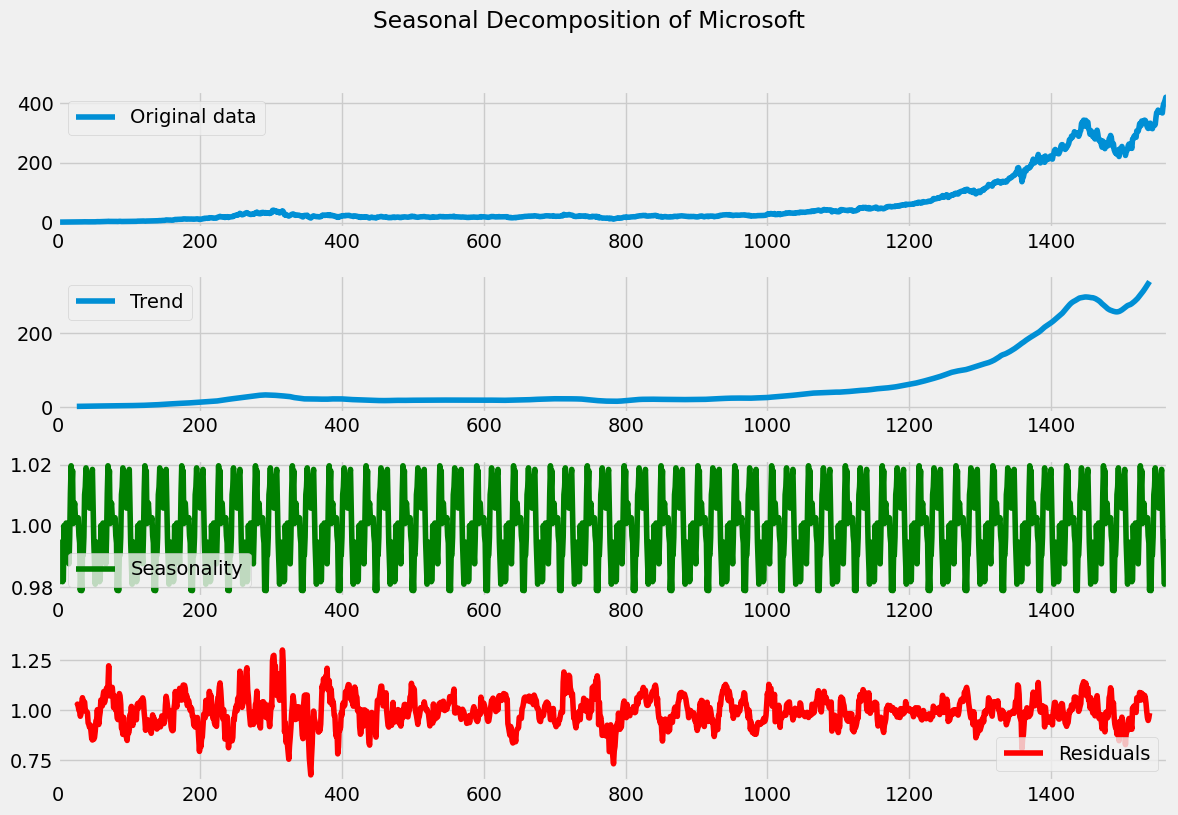

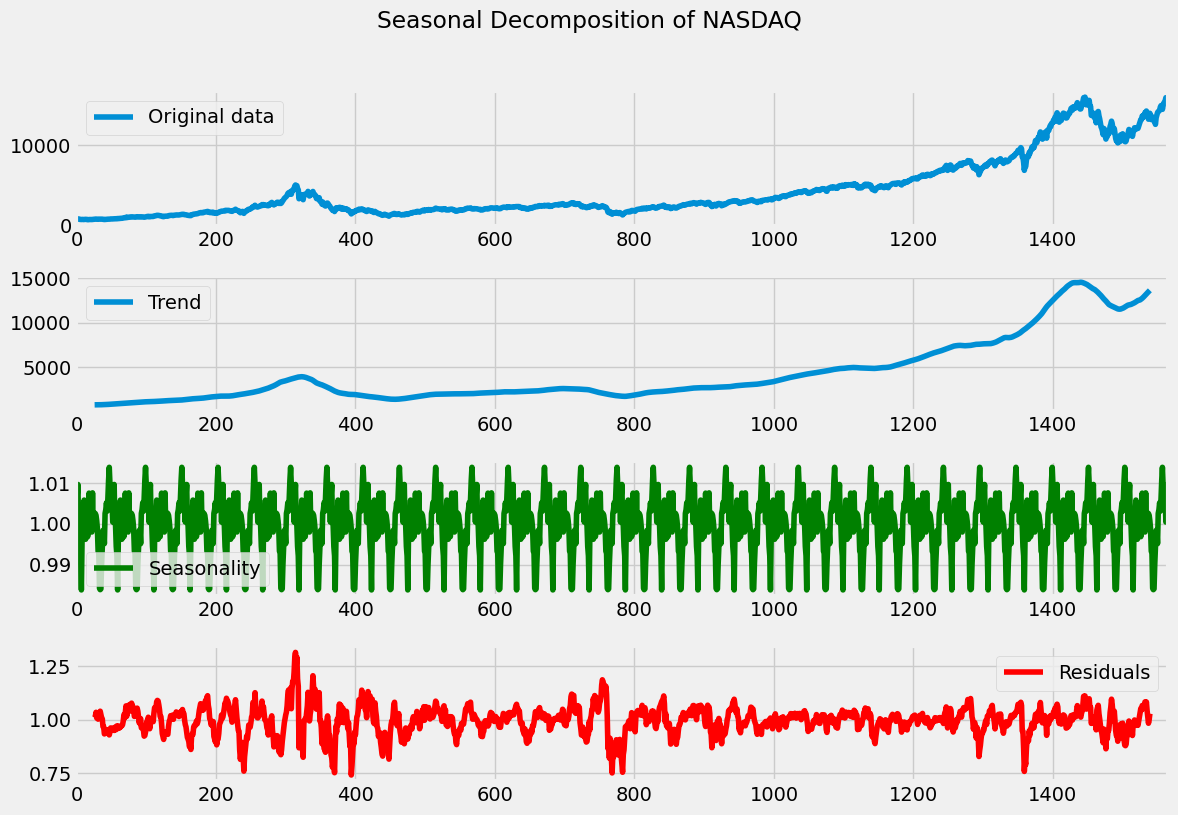

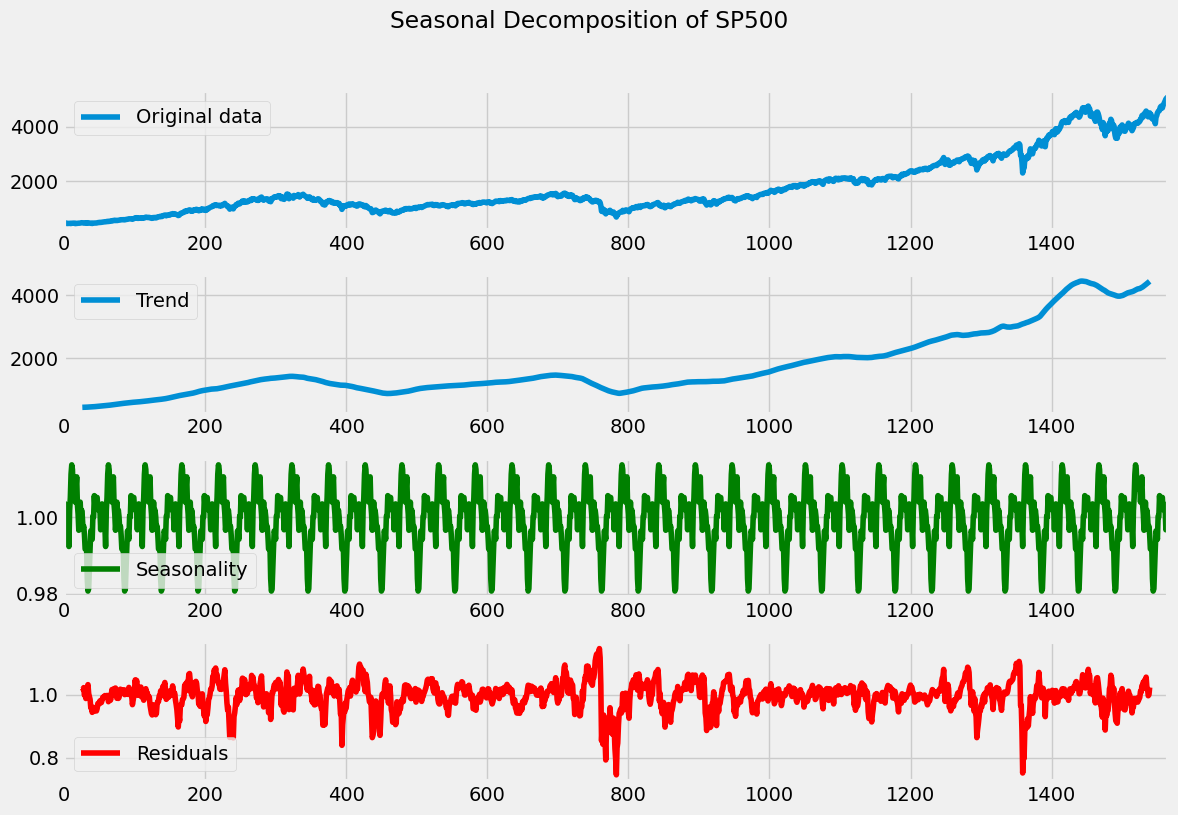

In [73]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

for df, name in zip(dfs, names):
    # period = 52 means we believe there is annual seasonal pattern
    result = seasonal_decompose(df['Close'], model='multiplicative', period=52)

    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    axes[0].plot(df.index, df['Close'], label='Original data')
    axes[0].legend()
    axes[1].plot(df.index, result.trend, label='Trend')
    axes[1].legend()
    axes[2].plot(df.index, result.seasonal, label='Seasonality', color='green')
    axes[2].legend()
    axes[3].plot(df.index, result.resid, label='Residuals', color='red')
    axes[3].legend()

    # Set the x-axis limits to match the date range of the data
    axes[0].set_xlim(df.index.min(), df.index.max())
    axes[1].set_xlim(df.index.min(), df.index.max())
    axes[2].set_xlim(df.index.min(), df.index.max())
    axes[3].set_xlim(df.index.min(), df.index.max())

    # Format x-axis to display years
    #for ax in axes:
       # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.suptitle(f'Seasonal Decomposition of {name}', y=1.02)
    plt.tight_layout()
    plt.show()


Augmented Dickey-Fuller (ADF) test

In [74]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  result = adfuller(df['Close'])
  results_list.append({'Name': name, 'ADF Statistic': result[0], 'p-value': result[1]})

# converting list of dictionaries to df
adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic  p-value
   Amazon      -2.203649 0.204924
      CAC      -1.423293 0.571059
      IBM      -1.031451 0.741621
Microsoft       3.880300 1.000000
   NASDAQ       1.524967 0.997614
    SP500       1.740065 0.998222


### Log Transformation

Log transformation is a technique used to stabilize variance, reduce skewness, and make the data conform more closely to the assumptions of statistical tests and models. It involves taking the logarithm of the values in a dataset, typically using the natural logarithm (base e) or the base 10 logarithm.

In [75]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()

  result = adfuller(timeseries_log_diff)

  adf_statistic = result[0]
  p_value = result[1]

  critical_values = result[4]

  critical_value_1pct = critical_values['1%']
  critical_value_5pct = critical_values['5%']
  critical_value_10pct = critical_values['10%']

  if p_value < 0.05:
    stationarity = 'Stationary'
  else:
    stationarity = 'Not stationary'

  results_list.append({'Name': name, 'ADF Statistic': adf_statistic,
                      'p-value': p_value, 'Critical Value (1%)': critical_value_1pct,
                      'Critical Value (5%)': critical_value_5pct,
                      'Critical Value (10%)': critical_value_10pct, 'Stationarity': stationarity})

adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic      p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
   Amazon     -27.457952 0.000000e+00            -3.435043            -2.863613             -2.567873   Stationary
      CAC     -10.719526 3.177184e-19            -3.434576            -2.863406             -2.567764   Stationary
      IBM     -19.460551 0.000000e+00            -3.434549            -2.863395             -2.567757   Stationary
Microsoft     -17.221004 6.279982e-30            -3.434554            -2.863397             -2.567759   Stationary
   NASDAQ     -15.106139 7.814343e-28            -3.434560            -2.863399             -2.567760   Stationary
    SP500     -15.941552 7.530593e-29            -3.434560            -2.863399             -2.567760   Stationary


Now, everything is ok, the data is stationary.

In [76]:
normality_results = []

for df, name in zip(dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()
  stat, p = normaltest(timeseries_log_diff)

  alpha = 0.05
  if p > alpha:
    normality = 'Normally distributed (fail to reject H0)'
  else:
    normality = 'Is not normally distributed (reject H0)'

  normality_results.append({'Name': name, 'Test Statistic': stat, 'p-value': p, 'Normality': normality})

normality_df = pd.DataFrame(normality_results)

print(normality_df.to_string(index=False))

     Name  Test Statistic      p-value                               Normality
   Amazon     2796.316729 0.000000e+00 Is not normally distributed (reject H0)
      CAC      383.132115 6.366757e-84 Is not normally distributed (reject H0)
      IBM      122.383960 2.658648e-27 Is not normally distributed (reject H0)
Microsoft      122.262702 2.824826e-27 Is not normally distributed (reject H0)
   NASDAQ      385.077328 2.407247e-84 Is not normally distributed (reject H0)
    SP500      361.871011 2.634562e-79 Is not normally distributed (reject H0)


There is a need to see why data is not normally distributed, so we can check with the help of skewness.

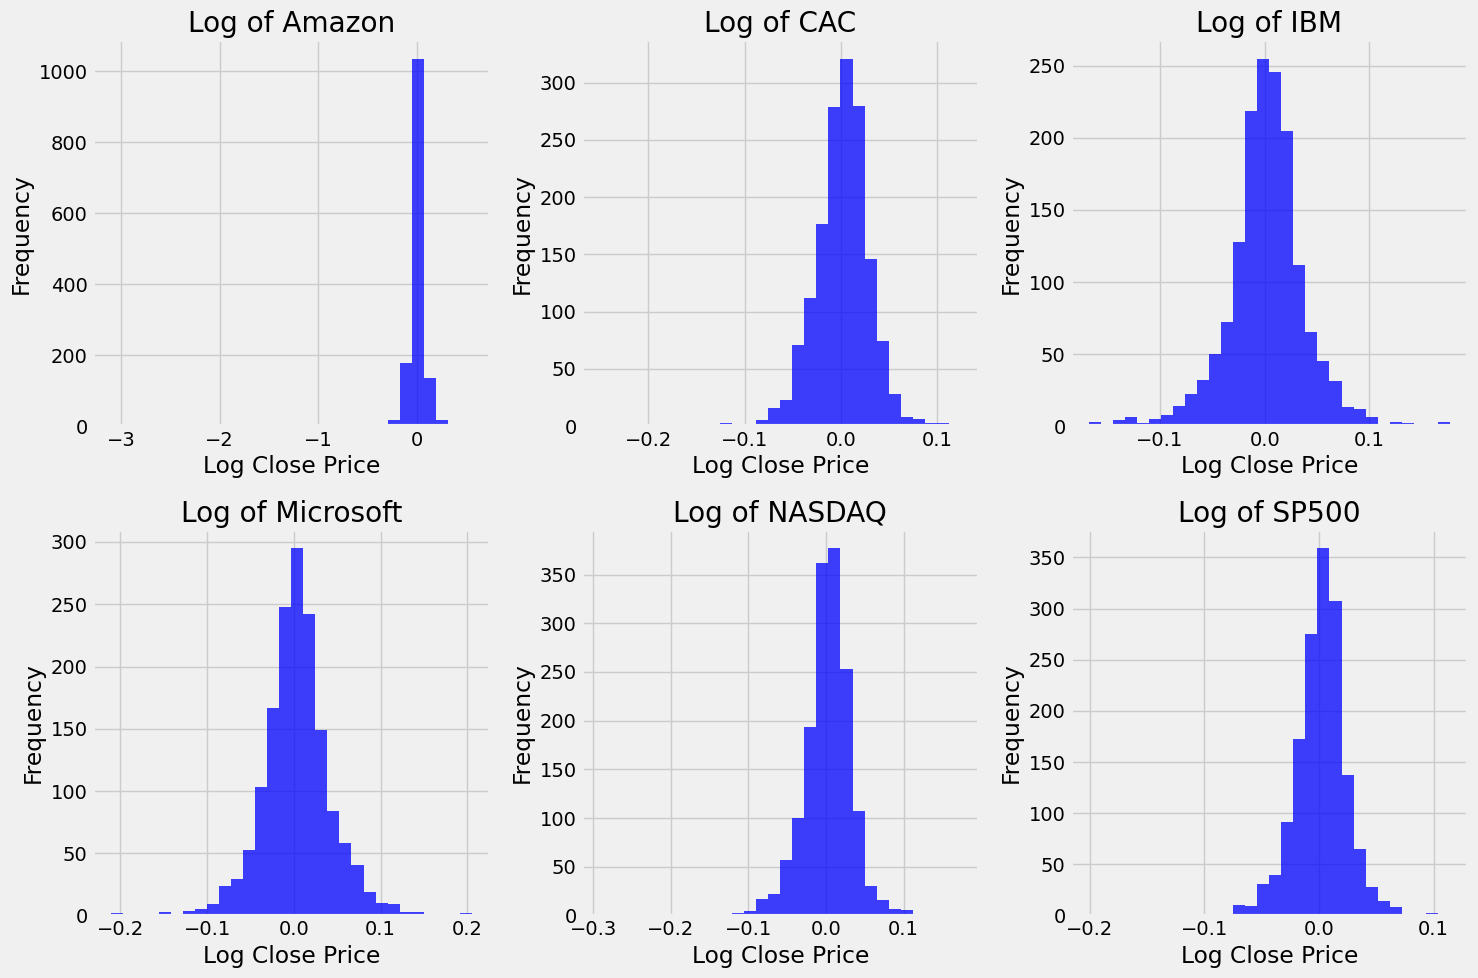

In [77]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, df, name in zip(axes, dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()
  ax.hist(timeseries_log_diff, bins=30, alpha=0.75, color='blue')
  ax.set_title(f'Log of {name}')
  ax.set_xlabel('Log Close Price')
  ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the skewness of all the graphs, they are all likely to be distributed normally, so we can fit the model now!

# Fit the model

## ARIMA (AutoRegressive Integrated Moving Average)

In [78]:
def arima_model(df):
  shape = df.shape[0]
  df_new = df[['Close']]
  df_new['Close'] = np.log(df_new['Close'])

  train_set = df_new.iloc[:ceil(shape * 0.8)]
  valid_set = df_new.iloc[ceil(shape * 0.8):]

  print('Training Set:', train_set.shape)
  print('Validation Set:', valid_set.shape)

  training = train_set['Close']
  validation = valid_set['Close']

  model = auto_arima(training, start_p=0, start_q=0, max_p=3, max_q=3, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
  model.fit(training)

  forecast = model.predict(n_periods=len(validation))
  forecast.index = validation.index
  forecast = pd.DataFrame(forecast,columns =['Prediction'])
  rmse = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
  print('RMSE value on validation set:', rmse)
  plt.plot(train_set['Close'])
  plt.plot(valid_set['Close'])
  plt.plot(forecast['Prediction'])
  plt.title('Stocks Price Prediction \n')
  plt.xlabel('Date')
  plt.ylabel('Actual Stock Price')
  plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
  plt.show()

In [79]:
amazon.set_index('Date',inplace=True)
cac.set_index('Date',inplace=True)
ibm.set_index('Date',inplace=True)
microsoft.set_index('Date',inplace=True)
nasdaq.set_index('Date',inplace=True)
sp500.set_index('Date',inplace=True)

Training Set: (1120, 1)
Validation Set: (279, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2460.170, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2458.578, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2458.606, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2455.699, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2456.580, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.897 seconds
RMSE value on validation set: 2.3199755530816186


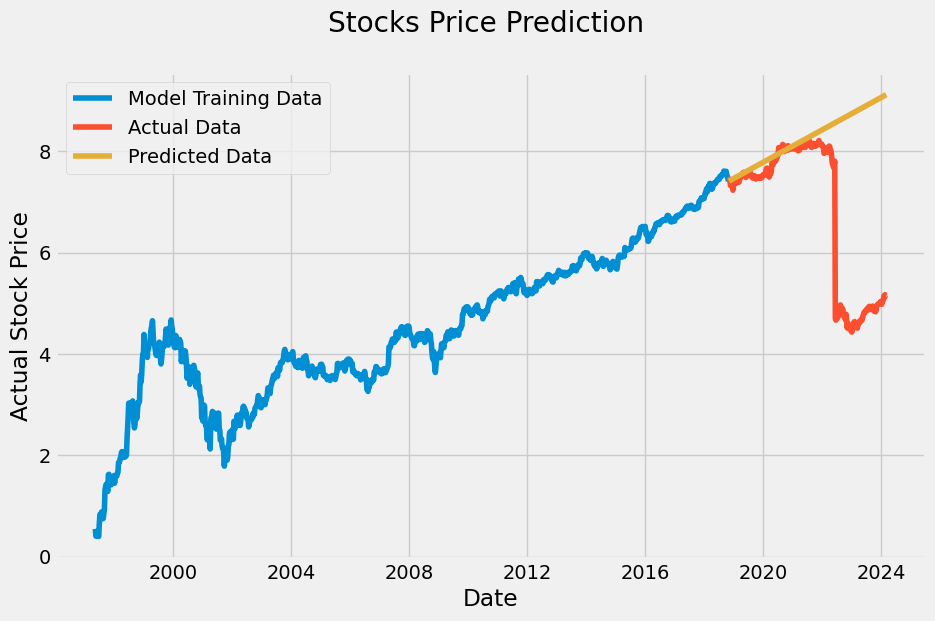

In [80]:
arima_model(amazon)

Training Set: (1252, 1)
Validation Set: (312, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5269.008, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5273.468, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5273.446, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5270.273, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5271.469, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5271.468, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5269.468, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5274.620, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5272.621, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5272.622, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5274.590, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5270.620, Time=0.78 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 4.693 seconds
RMSE value on validation se

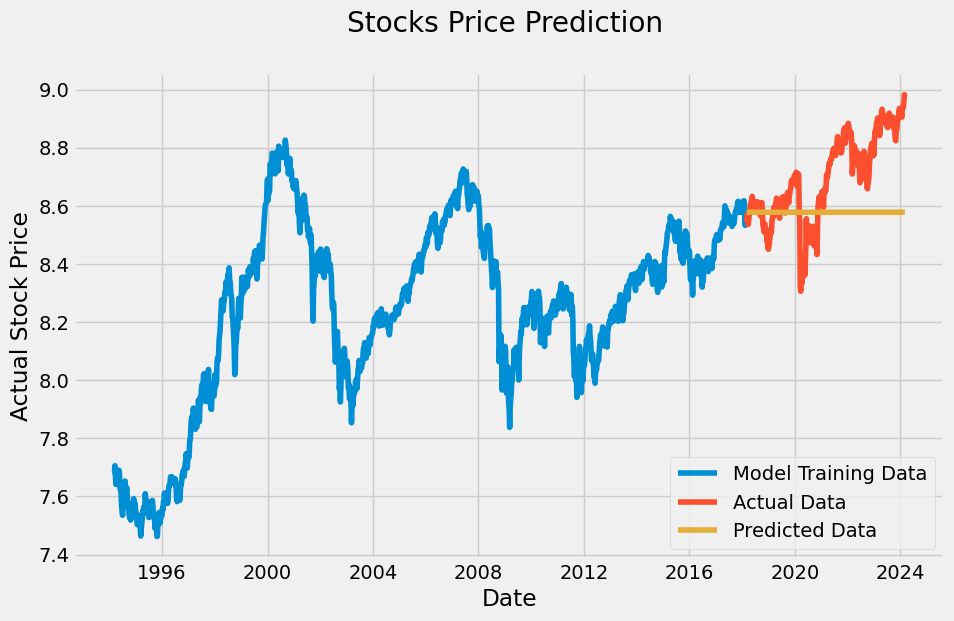

In [81]:
arima_model(cac)

Training Set: (1253, 1)
Validation Set: (313, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4691.057, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4691.559, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4691.306, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4688.357, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4692.726, Time=0.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4691.533, Time=0.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4690.959, Time=2.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4690.390, Time=1.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4689.453, Time=0.74 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-4690.109, Time=1.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 8.013 seconds
RMSE value on validation set: 0.4494707763532927


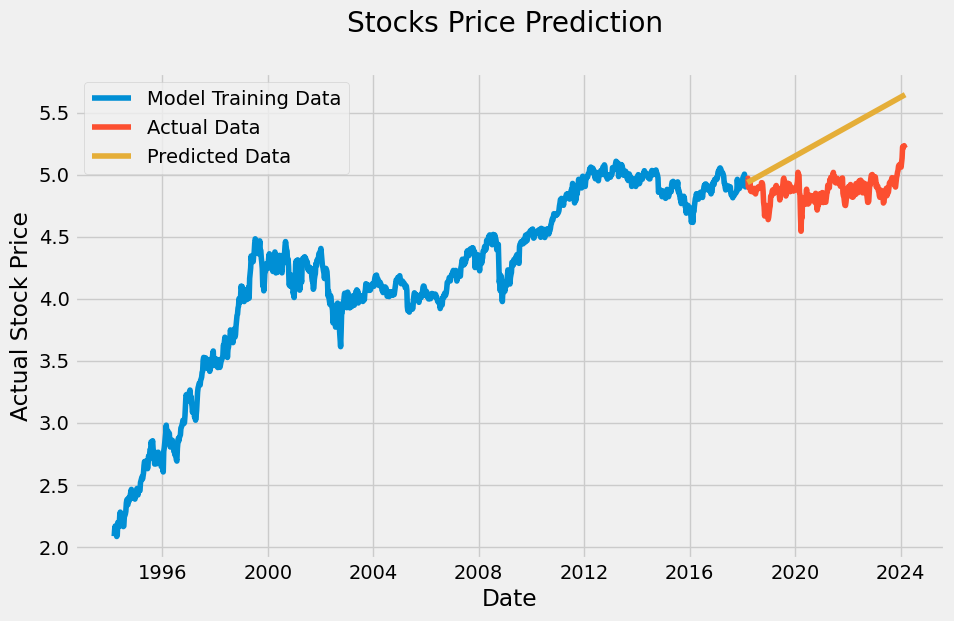

In [82]:
arima_model(ibm)

Training Set: (1253, 1)
Validation Set: (313, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4453.735, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4452.103, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4452.096, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4448.415, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4450.021, Time=0.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.400 seconds
RMSE value on validation set: 0.37884877408724704


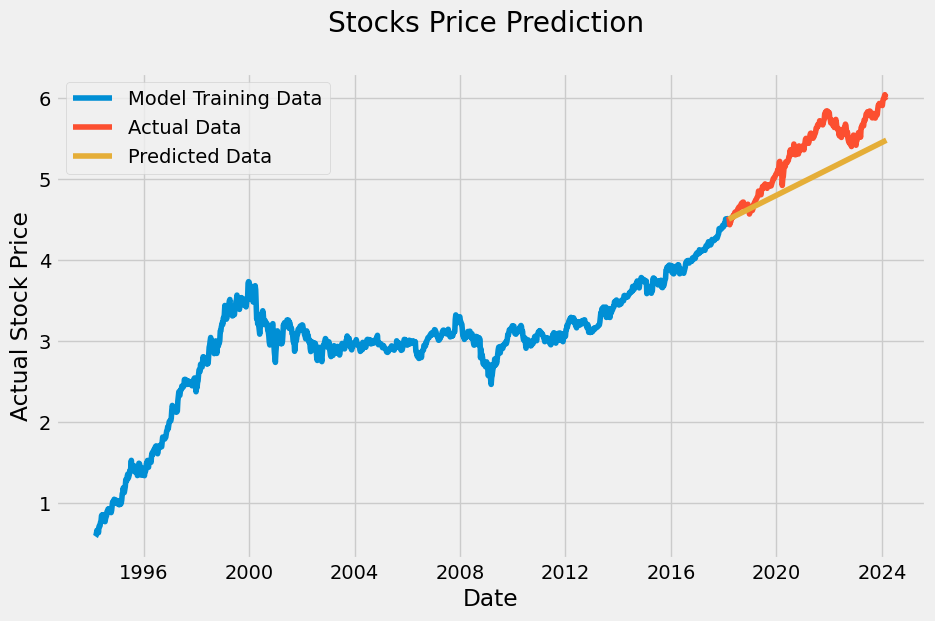

In [83]:
arima_model(microsoft)

Training Set: (1252, 1)
Validation Set: (312, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5071.100, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5069.586, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5069.554, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5069.189, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5068.028, Time=1.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 3.019 seconds
RMSE value on validation set: 0.18580860554214484


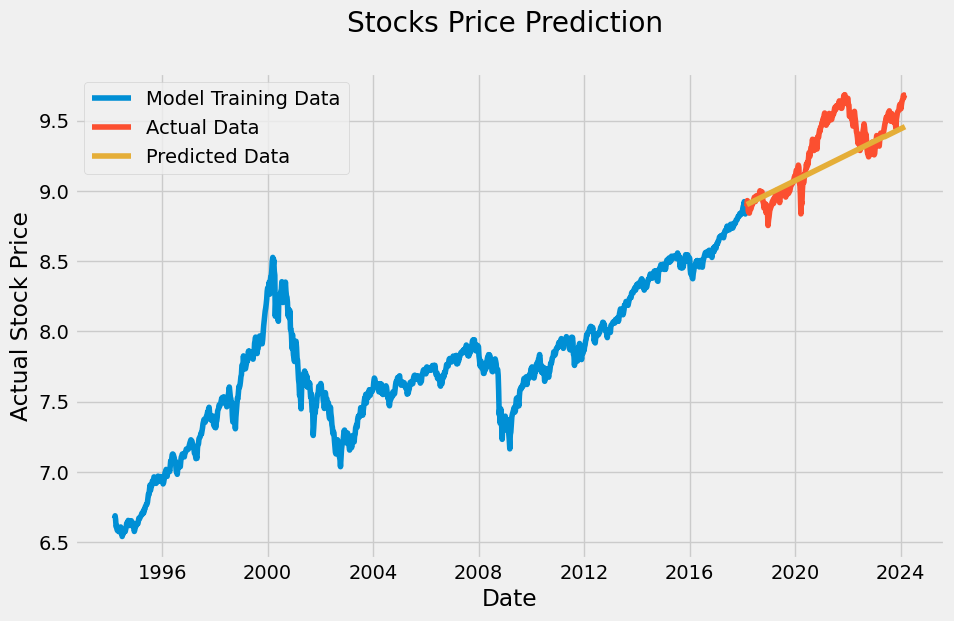

In [84]:
arima_model(nasdaq)

Training Set: (1252, 1)
Validation Set: (312, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5837.765, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5843.814, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5843.105, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5835.175, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5844.839, Time=0.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5845.627, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5843.810, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5842.109, Time=1.92 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5842.308, Time=0.89 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 7.582 seconds
RMSE value on validation set: 0.11021683579548214


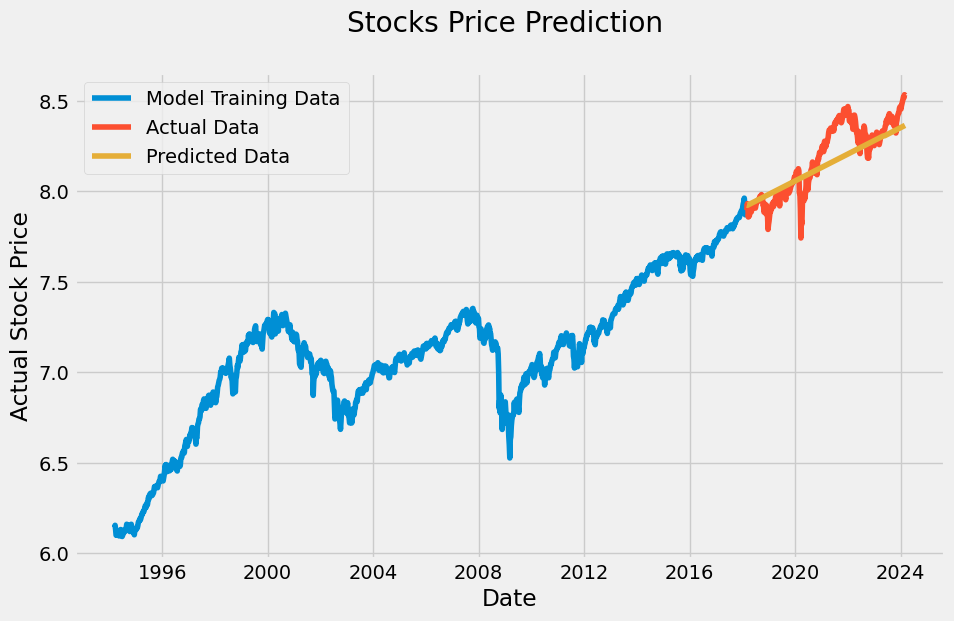

In [85]:
arima_model(sp500)

In [86]:
rmse_values = [2.3199, 0.1894, 0.4494, 0.3788, 0.1858, 0.1102]
names = ['AMAZON', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']
rmse_df = pd.DataFrame({'Name': names, 'RMSE': rmse_values})

print(rmse_df.to_string(index=False))

     Name   RMSE
   AMAZON 2.3199
      CAC 0.1894
      IBM 0.4494
Microsoft 0.3788
   NASDAQ 0.1858
    SP500 0.1102


## Conclusion on ARIMA
+ The best RMSE on 6 datasets with ARIMA is 0.1102 on SP500.
+ The worst RMSE is 2.3199 on AMAZON.

## LSTM

importing libraries for lstm

In [101]:
!pip install pandas-ta
import pandas_ta as ta
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

### SP500

In [93]:
sp500.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [94]:
sp500.dropna(inplace=True)
sp500.shape

(1564, 5)

In [98]:
sp500.drop(["Volume"], axis = 1, inplace =True)

In [99]:
#adding technical indicators
sp500['RSI'] = ta.rsi(sp500.Close, length = 14)
sp500['EMAF'] = ta.ema(sp500.Close, length = 20)
sp500['EMAM'] = ta.ema(sp500.Close, length = 50)
sp500['EMAS'] = ta.ema(sp500.Close, length = 100)

sp500['Target'] = sp500['Close']-sp500.Open
sp500['Target'] = sp500['Target'].shift(-1)

sp500['TargetClass'] = [1 if sp500.Target[i]>0 else 0 for i in range(len(sp500))]

sp500['TargetNextClose'] = sp500['Close'].shift(-1)

sp500.dropna(inplace =True)

In [100]:
sp500

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,
1996-01-28,611.8300,621.7000,610.6500,621.6200,70.735773,597.814022,562.757126,508.312200,14.2200,1,635.8400
1996-02-04,621.6200,639.2600,621.4200,635.8400,75.210280,601.435544,565.623121,510.837503,20.5300,1,656.3700
1996-02-11,635.8400,661.0800,633.7100,656.3700,79.971609,606.667397,569.181822,513.719335,-8.3900,0,647.9800
1996-02-18,656.3700,664.2300,646.9900,647.9800,73.738449,610.601930,572.271947,516.377962,11.1000,1,659.0800
1996-02-25,647.9800,663.0000,638.7900,659.0800,76.363302,615.218889,575.676184,519.203745,-14.7100,0,644.3700
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-28,4853.4199,4906.6899,4844.0498,4890.9702,70.410206,4601.320235,4415.574771,4264.306390,65.6597,1,4958.6099
2024-02-04,4892.9502,4975.2900,4845.1499,4958.6099,72.588169,4635.347822,4436.870266,4278.054975,69.4200,1,5026.6099
2024-02-11,4957.1899,5030.0601,4918.0898,5026.6099,74.611374,4672.610877,4459.997310,4292.877845,-21.2603,0,5005.5698


In [102]:
#feature scaling
sc = MinMaxScaler(feature_range =(0,1))
sp500_scaled = sc.fit_transform(sp500)
print(sp500_scaled)

[[0.00000000e+00 0.00000000e+00 1.09904795e-03 ... 5.63378011e-01
  1.00000000e+00 5.25217181e-04]
 [2.21744049e-03 3.91147059e-03 3.58054616e-03 ... 5.74570713e-01
  1.00000000e+00 5.13321236e-03]
 [5.43827847e-03 8.77185147e-03 6.41226510e-03 ... 5.23272306e-01
  0.00000000e+00 3.25006187e-03]
 ...
 [9.84226456e-01 9.81957340e-01 9.93569256e-01 ... 5.00442919e-01
  0.00000000e+00 9.81318878e-01]
 [1.00000000e+00 9.86040327e-01 9.94080832e-01 ... 7.14612170e-01
  1.00000000e+00 1.00000000e+00]
 [9.91503941e-01 1.00000000e+00 1.00000000e+00 ... 4.96522990e-01
  0.00000000e+00 9.95674814e-01]]


In [103]:
X = []

backcandles = 30
print(sp500_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, sp500_scaled.shape[0]):
        X[j].append(sp500_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(sp500_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1464
[[[0.00000000e+00 0.00000000e+00 1.09904795e-03 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.21744049e-03 3.91147059e-03 3.58054616e-03 ... 8.74104056e-04
   7.26956937e-04 6.62086318e-04]
  [5.43827847e-03 8.77185147e-03 6.41226510e-03 ... 2.13688370e-03
   1.62961811e-03 1.41764766e-03]
  ...
  [5.45186851e-03 9.08592741e-03 5.37773149e-03 ... 1.28897184e-02
   1.53283537e-02 1.59080832e-02]
  [1.14745184e-02 9.72744423e-03 1.17393067e-02 ... 1.31398695e-02
   1.57154075e-02 1.63914921e-02]
  [1.13861832e-02 9.94351066e-03 1.21171765e-02 ... 1.34376863e-02
   1.61182180e-02 1.68814747e-02]]

 [[2.21744049e-03 3.91147059e-03 3.58054616e-03 ... 8.74104056e-04
   7.26956937e-04 6.62086318e-04]
  [5.43827847e-03 8.77185147e-03 6.41226510e-03 ... 2.13688370e-03
   1.62961811e-03 1.41764766e-03]
  [1.00883350e-02 9.47351049e-03 9.47208833e-03 ... 3.08653750e-03
   2.41342530e-03 2.11468900e-03]
  ...
  [1.14745184e-02 9.72744423e-03 1.17393067e-02 ... 1.31398695e-02
   1.

In [104]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1147
(1147, 30, 8)
(287, 30, 8)
(1147, 1)
(287, 1)
[[0.00415011]
 [0.00497834]
 [0.01055821]
 ...
 [0.49533145]
 [0.49374455]
 [0.49752654]]


In [105]:
#modeling
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
69/69 [==============================] - 4s 24ms/step - loss: 0.0014 - val_loss: 3.4146e-04
Epoch 2/30
69/69 [==============================] - 1s 21ms/step - loss: 1.8179e-04 - val_loss: 2.4998e-04
Epoch 3/30
69/69 [==============================] - 3s 50ms/step - loss: 1.6173e-04 - val_loss: 1.6657e-04
Epoch 4/30
69/69 [==============================] - 3s 44ms/step - loss: 1.4585e-04 - val_loss: 1.6373e-04
Epoch 5/30
69/69 [==============================] - 1s 19ms/step - loss: 1.3865e-04 - val_loss: 1.4721e-04
Epoch 6/30
69/69 [==============================] - 1s 18ms/step - loss: 1.2755e-04 - val_loss: 2.0614e-04
Epoch 7/30
69/69 [==============================] - 1s 19ms/step - loss: 1.3536e-04 - val_loss: 2.1324e-04
Epoch 8/30
69/69 [==============================] - 1s 18ms/step - loss: 1.1715e-04 - val_loss: 2.0396e-04
Epoch 9/30
69/69 [==============================] - 1s 22ms/step - loss: 1.2476e-04 - val_loss: 1.5830e-04
Epoch 10/30
69/69 [======================

In [106]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 1s 18ms/step
[0.4880902] [0.50303908]
[0.49076015] [0.50906114]
[0.4964576] [0.50236348]
[0.50299436] [0.50983774]
[0.49649605] [0.51537944]
[0.50239414] [0.51185781]
[0.50843424] [0.50548116]
[0.50637823] [0.47889704]
[0.5003051] [0.47904296]
[0.47474408] [0.45455749]


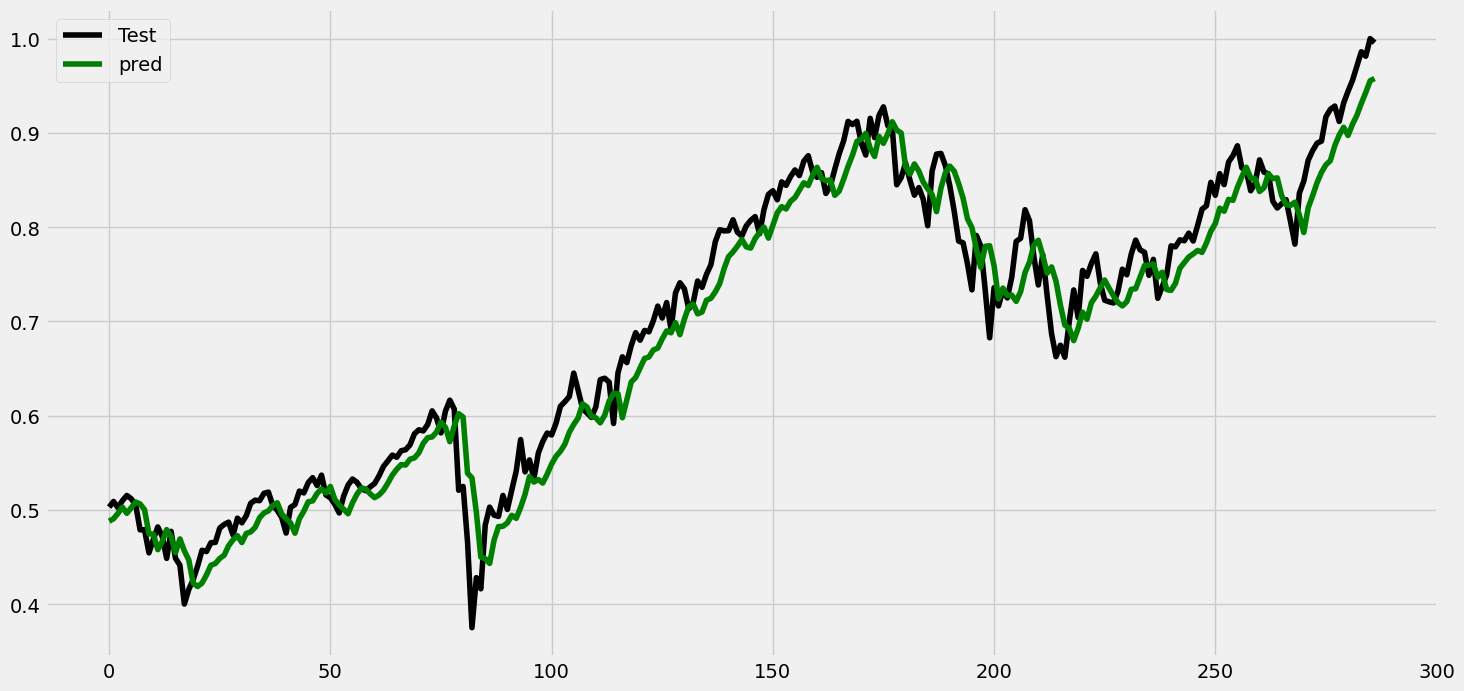

In [107]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [108]:
#calculating mae, mse, rmse

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.02809613624920186
Mean Squared Error: 0.0011672716397041435
Root Mean Squared Error: 0.03416535730391449


All the codes below have the same logic but for different datasets.

### Amazon

In [110]:
amazon.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [111]:
amazon.dropna(inplace=True)
amazon.shape

(1399, 5)

In [112]:
amazon.drop(["Volume"], axis = 1, inplace =True)

In [113]:
amazon['RSI'] = ta.rsi(amazon.Close, length = 14)
amazon['EMAF'] = ta.ema(amazon.Close, length = 20)
amazon['EMAM'] = ta.ema(amazon.Close, length = 50)
amazon['EMAS'] = ta.ema(amazon.Close, length = 100)

amazon['Target'] = amazon['Close']-amazon.Open
amazon['Target'] = amazon['Target'].shift(-1)

amazon['TargetClass'] = [1 if amazon.Target[i]>0 else 0 for i in range(len(amazon))]

amazon['TargetNextClose'] = amazon['Close'].shift(-1)

amazon.dropna(inplace =True)

In [114]:
amazon

,Open,High,Low,Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,
1999-04-11,172.625,195.7500,166.00,91.4375,75.692030,59.791654,40.428128,18.827709,-81.1250,0,95.0000
1999-04-18,176.125,192.0000,151.00,95.0000,76.820829,63.144829,42.568201,20.336071,-83.9375,0,105.0625
1999-04-25,189.000,216.5000,153.50,105.0625,79.689751,67.136989,45.018958,22.013822,-122.9687,0,86.0313
1999-05-02,209.000,221.2500,165.00,86.0313,63.645083,68.936447,46.627285,23.281495,-98.6875,0,68.1875
1999-05-09,166.875,167.0625,131.00,68.1875,52.892183,68.865118,47.472784,24.170723,-70.4375,0,66.1875
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-28,156.890,160.7200,153.90,159.1200,62.728497,145.145009,225.456231,633.941782,12.4700,1,171.8100
2024-02-04,159.340,172.5000,154.81,171.8100,69.994041,147.684532,223.352457,624.790658,4.2500,1,174.4500
2024-02-11,170.200,175.0000,167.65,174.4500,71.249670,150.233624,221.434713,615.873021,-5.2900,0,169.5100


In [116]:
sc = MinMaxScaler(feature_range =(0,1))
amazon_scaled = sc.fit_transform(amazon)
print(amazon_scaled)

[[0.04459898 0.04995196 0.04501893 ... 0.42983305 0.         0.02397553]
 [0.04553529 0.04895605 0.04081129 ... 0.42597942 0.         0.02668533]
 [0.04897956 0.05546263 0.04151256 ... 0.37249957 0.         0.02156028]
 ...
 [0.04395025 0.04444128 0.04548177 ... 0.5337408  0.         0.04404086]
 [0.04518083 0.04454485 0.0449488  ... 0.55079956 1.         0.0455166 ]
 [0.04331624 0.04464046 0.04494599 ... 0.53965998 0.         0.04544659]]


In [117]:
X = []

backcandles = 30
print(amazon_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, amazon_scaled.shape[0]):
        X[j].append(amazon_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(amazon_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1299
[[[4.45989797e-02 4.99519562e-02 4.50189261e-02 ... 1.47001373e-02
   7.97012891e-03 3.80751233e-05]
  [4.55352867e-02 4.89560509e-02 4.08112877e-02 ... 1.56799895e-02
   8.61857320e-03 5.36472400e-04]
  [4.89795591e-02 5.54626324e-02 4.15125607e-02 ... 1.68465629e-02
   9.36115486e-03 1.09083962e-03]
  ...
  [2.22613688e-02 2.17014413e-02 1.91945452e-02 ... 1.65326834e-02
   1.29794594e-02 6.47407724e-03]
  [1.84994208e-02 2.01743865e-02 1.83880812e-02 ... 1.68822893e-02
   1.32368852e-02 6.73788688e-03]
  [1.95527663e-02 2.03569691e-02 1.69329396e-02 ... 1.69759585e-02
   1.33891567e-02 6.94412836e-03]]

 [[4.55352867e-02 4.89560509e-02 4.08112877e-02 ... 1.56799895e-02
   8.61857320e-03 5.36472400e-04]
  [4.89795591e-02 5.54626324e-02 4.15125607e-02 ... 1.68465629e-02
   9.36115486e-03 1.09083962e-03]
  [5.43298850e-02 5.67241125e-02 4.47384169e-02 ... 1.73723936e-02
   9.84847952e-03 1.50970764e-03]
  ...
  [1.84994208e-02 2.01743865e-02 1.83880812e-02 ... 1.68822893e-02
   1.

In [118]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1015
(1015, 30, 8)
(254, 30, 8)
(1015, 1)
(254, 1)
[[0.01857275]
 [0.01938064]
 [0.02347059]
 ...
 [0.49316657]
 [0.49472311]
 [0.49974011]]


In [119]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
61/61 [==============================] - 4s 29ms/step - loss: 7.3522e-04 - val_loss: 0.0011
Epoch 2/30
61/61 [==============================] - 2s 40ms/step - loss: 3.1055e-05 - val_loss: 0.0014
Epoch 3/30
61/61 [==============================] - 3s 41ms/step - loss: 3.6244e-05 - val_loss: 9.6297e-04
Epoch 4/30
61/61 [==============================] - 2s 36ms/step - loss: 2.7864e-05 - val_loss: 8.1291e-04
Epoch 5/30
61/61 [==============================] - 3s 46ms/step - loss: 2.7227e-05 - val_loss: 7.7597e-04
Epoch 6/30
61/61 [==============================] - 2s 36ms/step - loss: 3.2511e-05 - val_loss: 0.0010
Epoch 7/30
61/61 [==============================] - 2s 36ms/step - loss: 2.9955e-05 - val_loss: 7.4296e-04
Epoch 8/30
61/61 [==============================] - 2s 28ms/step - loss: 2.2233e-05 - val_loss: 9.2781e-04
Epoch 9/30
61/61 [==============================] - 2s 28ms/step - loss: 2.9369e-05 - val_loss: 6.8511e-04
Epoch 10/30
61/61 [==============================

In [120]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

8/8 [==============================] - 1s 26ms/step
[0.49425066] [0.5236914]
[0.49957997] [0.52687719]
[0.5113471] [0.50735853]
[0.52040464] [0.50170868]
[0.51486886] [0.48939641]
[0.50789016] [0.4764136]
[0.49975067] [0.48421244]
[0.4904273] [0.50188911]
[0.48610416] [0.51309995]
[0.4961713] [0.50834147]


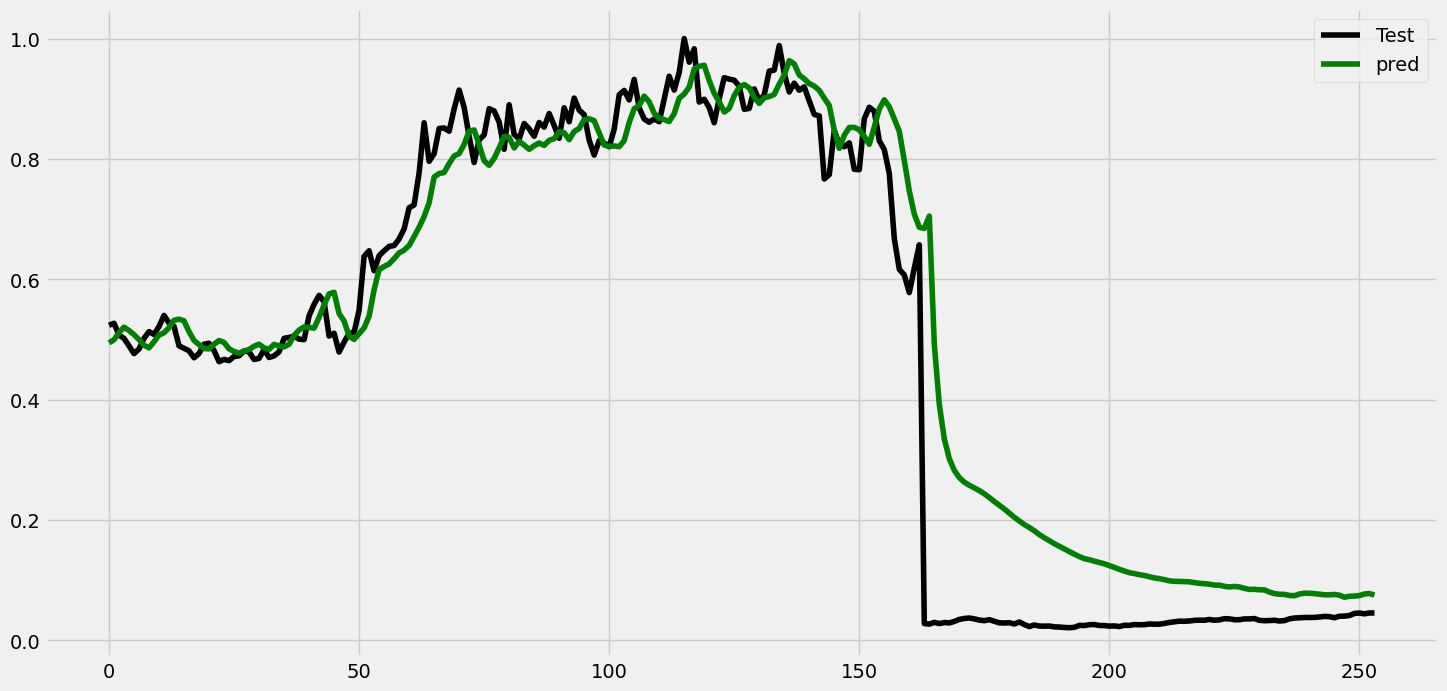

In [121]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [122]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.06890841224951792
Mean Squared Error: 0.011825160878173858
Root Mean Squared Error: 0.10874355557077328


### CAC

In [123]:
cac.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [124]:
cac.dropna(inplace=True)
cac.shape

(1564, 5)

In [125]:
cac.drop(["Volume"], axis = 1, inplace =True)

In [126]:
cac['RSI'] = ta.rsi(cac.Close, length = 14)
cac['EMAF'] = ta.ema(cac.Close, length = 20)
cac['EMAM'] = ta.ema(cac.Close, length = 50)
cac['EMAS'] = ta.ema(cac.Close, length = 100)

cac['Target'] = cac['Close']-cac.Open
cac['Target'] = cac['Target'].shift(-1)

cac['TargetClass'] = [1 if cac.Target[i]>0 else 0 for i in range(len(cac))]

cac['TargetNextClose'] = cac['Close'].shift(-1)

cac.dropna(inplace =True)

In [127]:
sc = MinMaxScaler(feature_range =(0,1))
cac_scaled = sc.fit_transform(cac)
print(cac_scaled)

[[3.20116669e-03 1.18248527e-03 2.47612330e-01 ... 5.91641255e-01
  1.00000000e+00 1.19819295e-02]
 [4.03895184e-03 1.14406697e-02 2.52071302e-01 ... 5.13390296e-01
  0.00000000e+00 1.75016947e-03]
 [1.12980326e-02 7.44416886e-03 2.49453487e-01 ... 5.47590652e-01
  0.00000000e+00 3.95574867e-04]
 ...
 [9.73952812e-01 9.51612919e-01 9.77992983e-01 ... 6.19659883e-01
  1.00000000e+00 9.67007726e-01]
 [9.88152063e-01 9.70813786e-01 9.83152113e-01 ... 7.17611334e-01
  1.00000000e+00 1.00000000e+00]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 5.33332327e-01
  0.00000000e+00 9.93873543e-01]]


In [128]:
X = []

backcandles = 30
print(cac_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, cac_scaled.shape[0]):
        X[j].append(cac_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(cac_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1464
[[[3.20116669e-03 1.18248527e-03 2.47612330e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [4.03895184e-03 1.14406697e-02 2.52071302e-01 ... 2.33134302e-03
   9.27056691e-04 3.36904805e-04]
  [1.12980326e-02 7.44416886e-03 2.49453487e-01 ... 3.39457473e-03
   1.36923815e-03 4.26563119e-04]
  ...
  [5.05256843e-03 1.11645902e-02 2.50075850e-01 ... 2.90035670e-02
   2.00033704e-02 9.83563771e-03]
  [1.40527253e-02 1.12843355e-02 2.54788954e-01 ... 2.80175098e-02
   1.99079508e-02 9.85010378e-03]
  [6.93844693e-03 4.18110825e-03 2.53458653e-01 ... 2.69550946e-02
   1.97432684e-02 9.82512546e-03]]

 [[4.03895184e-03 1.14406697e-02 2.52071302e-01 ... 2.33134302e-03
   9.27056691e-04 3.36904805e-04]
  [1.12980326e-02 7.44416886e-03 2.49453487e-01 ... 3.39457473e-03
   1.36923815e-03 4.26563119e-04]
  [2.08239600e-03 3.65389611e-03 2.50280712e-01 ... 4.21805472e-03
   1.73469907e-03 4.82596003e-04]
  ...
  [1.40527253e-02 1.12843355e-02 2.54788954e-01 ... 2.80175098e-02
   1.

In [129]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1147
(1147, 30, 8)
(287, 30, 8)
(1147, 1)
(287, 1)
[[0.0034056 ]
 [0.00907994]
 [0.02164858]
 ...
 [0.58652451]
 [0.57583734]
 [0.56424433]]


In [131]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
69/69 [==============================] - 3s 23ms/step - loss: 0.0069 - val_loss: 6.2363e-04
Epoch 2/30
69/69 [==============================] - 1s 18ms/step - loss: 0.0014 - val_loss: 5.4855e-04
Epoch 3/30
69/69 [==============================] - 1s 20ms/step - loss: 0.0012 - val_loss: 7.2884e-04
Epoch 4/30
69/69 [==============================] - 2s 25ms/step - loss: 0.0012 - val_loss: 6.5433e-04
Epoch 5/30
69/69 [==============================] - 2s 29ms/step - loss: 0.0011 - val_loss: 6.0035e-04
Epoch 6/30
69/69 [==============================] - 2s 25ms/step - loss: 0.0011 - val_loss: 8.5921e-04
Epoch 7/30
69/69 [==============================] - 2s 33ms/step - loss: 0.0010 - val_loss: 5.4158e-04
Epoch 8/30
69/69 [==============================] - 2s 33ms/step - loss: 0.0011 - val_loss: 7.1446e-04
Epoch 9/30
69/69 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 6.5599e-04
Epoch 10/30
69/69 [==============================] - 1s 18ms/step - loss:

In [132]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 0s 9ms/step
[0.5848698] [0.57879916]
[0.5694763] [0.57453593]
[0.5900007] [0.5488352]
[0.58743197] [0.56551416]
[0.55530626] [0.5890492]
[0.57535595] [0.58893618]
[0.6050121] [0.56664271]
[0.6051092] [0.52286687]
[0.5756259] [0.5209854]
[0.52986145] [0.50149087]


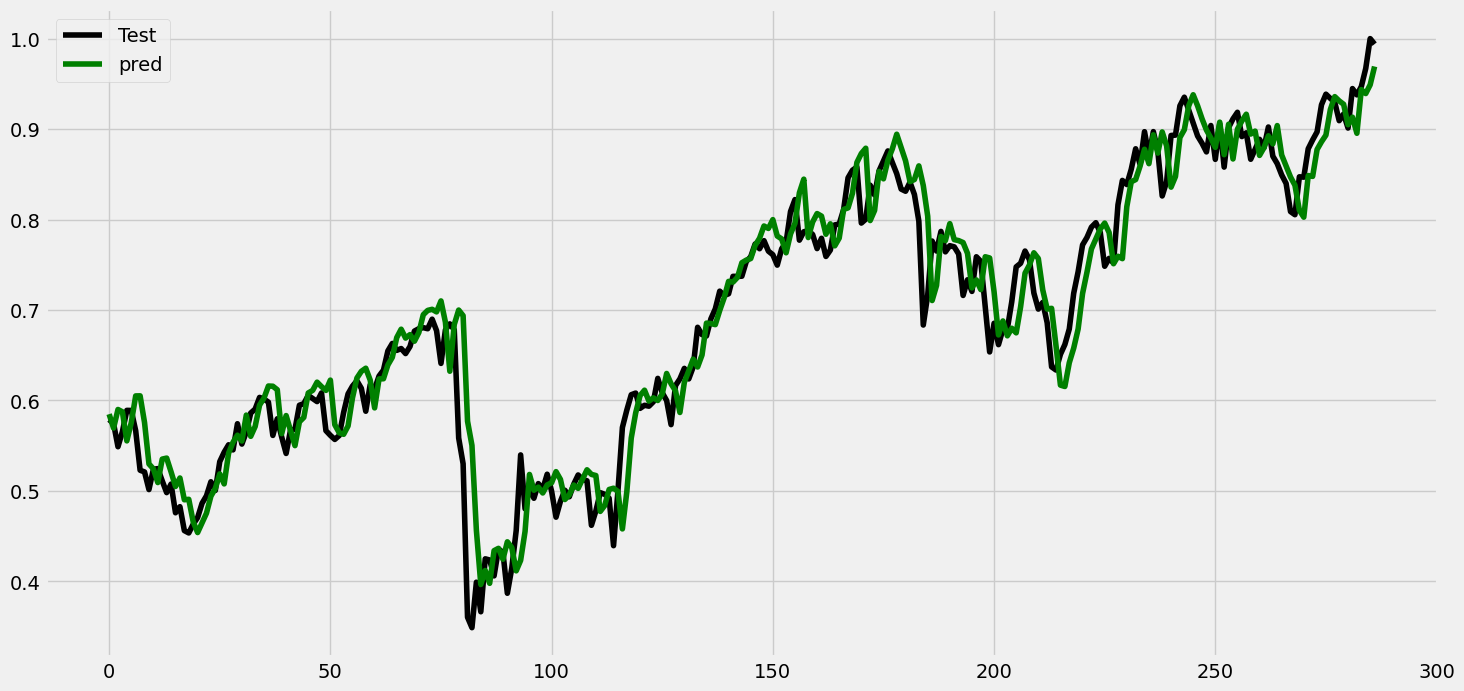

In [133]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [134]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.02791554792297146
Mean Squared Error: 0.0016149208319342703
Root Mean Squared Error: 0.04018607758831745


### Microsoft

In [135]:
microsoft.dropna(inplace=True)
microsoft.shape

(1566, 5)

In [136]:
microsoft.drop(["Volume"], axis = 1, inplace =True)

In [137]:
microsoft['RSI'] = ta.rsi(microsoft.Close, length = 14)
microsoft['EMAF'] = ta.ema(microsoft.Close, length = 20)
microsoft['EMAM'] = ta.ema(microsoft.Close, length = 50)
microsoft['EMAS'] = ta.ema(microsoft.Close, length = 100)

microsoft['Target'] = microsoft['Close']-microsoft.Open
microsoft['Target'] = microsoft['Target'].shift(-1)

microsoft['TargetClass'] = [1 if microsoft.Target[i]>0 else 0 for i in range(len(microsoft))]

microsoft['TargetNextClose'] = microsoft['Close'].shift(-1)

microsoft.dropna(inplace =True)

In [138]:
sc = MinMaxScaler(feature_range =(0,1))
microsoft_scaled = sc.fit_transform(microsoft)
print(microsoft_scaled)

[[1.88538442e-01 1.88788883e-01 1.90800988e-01 ... 3.50717169e-01
  0.00000000e+00 0.00000000e+00]
 [1.86379840e-01 1.92497898e-01 1.91726037e-01 ... 3.41506075e-01
  0.00000000e+00 7.62449472e-04]
 [1.91313787e-01 2.07333960e-01 2.00453001e-01 ... 3.02650481e-01
  0.00000000e+00 5.22093832e-04]
 ...
 [9.73714398e-01 1.00000000e+00 9.98764542e-01 ... 7.34437431e-01
  0.00000000e+00 9.62193429e-01]
 [1.00000000e+00 9.99802186e-01 1.00000000e+00 ... 8.63565691e-01
  1.00000000e+00 9.77302873e-01]
 [9.57284356e-01 9.87735522e-01 9.84119222e-01 ... 8.03283946e-01
  0.00000000e+00 9.70566178e-01]]


In [139]:
X = []

backcandles = 30
print(microsoft_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, microsoft_scaled.shape[0]):
        X[j].append(microsoft_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(microsoft_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1466
[[[1.88538442e-01 1.88788883e-01 1.90800988e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.86379840e-01 1.92497898e-01 1.91726037e-01 ... 3.46506120e-05
   4.43766964e-05 6.47115070e-05]
  [1.91313787e-01 2.07333960e-01 2.00453001e-01 ... 1.46350036e-04
   1.23365599e-04 1.48240880e-04]
  ...
  [2.56688582e-01 2.65750952e-01 2.60617214e-01 ... 2.90984123e-03
   2.47827213e-03 2.48449644e-03]
  [2.67173219e-01 2.70696306e-01 2.72843097e-01 ... 3.02288694e-03
   2.58631189e-03 2.58894409e-03]
  [2.69023449e-01 2.71314475e-01 2.79277772e-01 ... 3.12235202e-03
   2.68884149e-03 2.69061945e-03]]

 [[1.86379840e-01 1.92497898e-01 1.91726037e-01 ... 3.46506120e-05
   4.43766964e-05 6.47115070e-05]
  [1.91313787e-01 2.07333960e-01 2.00453001e-01 ... 1.46350036e-04
   1.23365599e-04 1.48240880e-04]
  [2.08582600e-01 2.09497552e-01 2.12678884e-01 ... 2.22082130e-04
   1.87797095e-04 2.23780080e-04]
  ...
  [2.67173219e-01 2.70696306e-01 2.72843097e-01 ... 3.02288694e-03
   2.

In [140]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1148
(1148, 30, 8)
(288, 30, 8)
(1148, 1)
(288, 1)
[[0.00315927]
 [0.00315927]
 [0.00406944]
 ...
 [0.24492496]
 [0.24258584]
 [0.2445108 ]]


In [141]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
69/69 [==============================] - 7s 37ms/step - loss: 4.3760e-04 - val_loss: 6.0422e-04
Epoch 2/30
69/69 [==============================] - 2s 24ms/step - loss: 3.4773e-05 - val_loss: 1.1554e-04
Epoch 3/30
69/69 [==============================] - 1s 20ms/step - loss: 2.9226e-05 - val_loss: 9.2053e-05
Epoch 4/30
69/69 [==============================] - 1s 20ms/step - loss: 2.6428e-05 - val_loss: 5.7982e-05
Epoch 5/30
69/69 [==============================] - 2s 33ms/step - loss: 2.4545e-05 - val_loss: 3.6509e-05
Epoch 6/30
69/69 [==============================] - 3s 38ms/step - loss: 2.2548e-05 - val_loss: 4.6360e-05
Epoch 7/30
69/69 [==============================] - 2s 33ms/step - loss: 2.2113e-05 - val_loss: 2.9315e-05
Epoch 8/30
69/69 [==============================] - 2s 22ms/step - loss: 2.3018e-05 - val_loss: 4.3336e-05
Epoch 9/30
69/69 [==============================] - 2s 31ms/step - loss: 2.0621e-05 - val_loss: 2.6574e-05
Epoch 10/30
69/69 [==================

In [142]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 1s 19ms/step
[0.24343528] [0.25373653]
[0.24531339] [0.24406478]
[0.25117216] [0.25617795]
[0.2452786] [0.25826724]
[0.25052643] [0.25852546]
[0.25437137] [0.25326703]
[0.25683713] [0.24725739]
[0.2540343] [0.24512116]
[0.24893613] [0.24113038]
[0.24639142] [0.23925237]


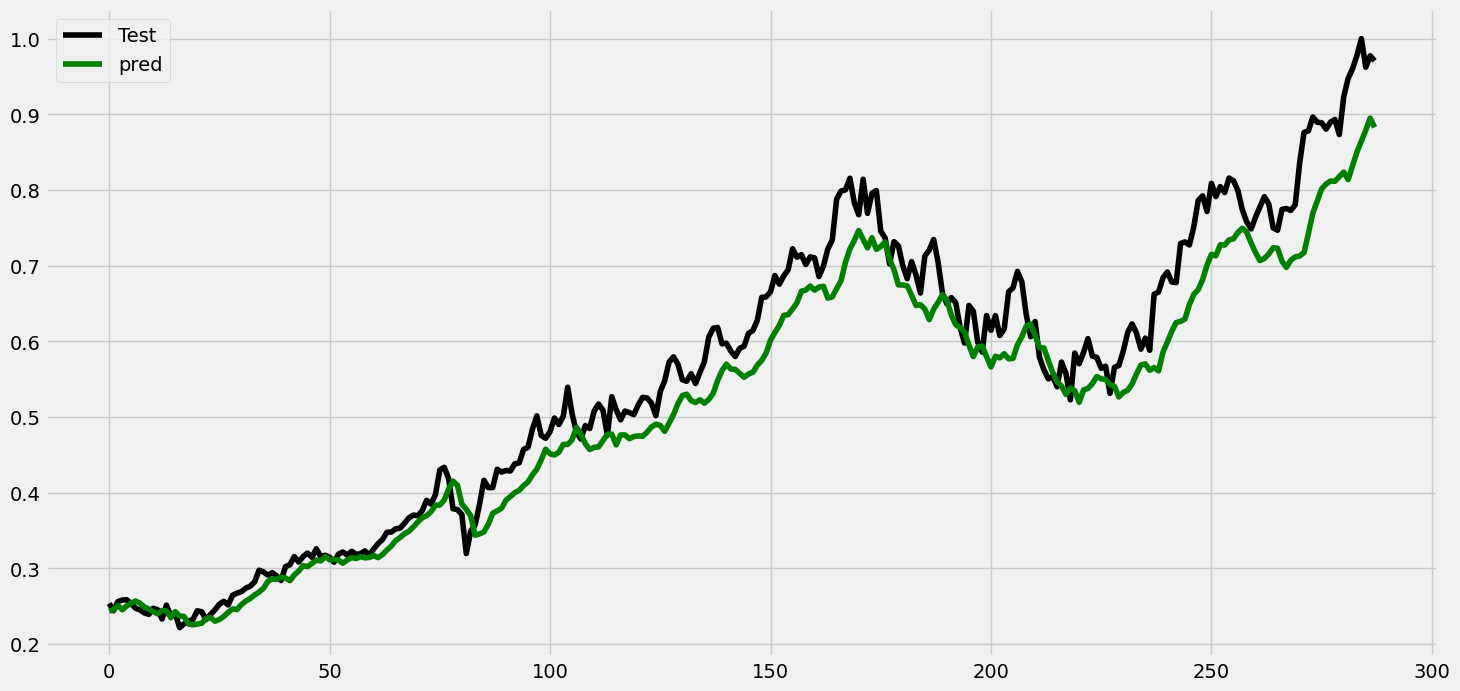

In [143]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [144]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.04181560965929963
Mean Squared Error: 0.0028350582612457305
Root Mean Squared Error: 0.053245265153304765


### IBM

In [145]:
ibm.drop(["Volume"], axis = 1, inplace =True)

In [146]:
ibm['RSI'] = ta.rsi(ibm.Close, length = 14)
ibm['EMAF'] = ta.ema(ibm.Close, length = 20)
ibm['EMAM'] = ta.ema(ibm.Close, length = 50)
ibm['EMAS'] = ta.ema(ibm.Close, length = 100)

ibm['Target'] = ibm['Close']-ibm.Open
ibm['Target'] = ibm['Target'].shift(-1)

ibm['TargetClass'] = [1 if ibm.Target[i]>0 else 0 for i in range(len(ibm))]

ibm['TargetNextClose'] = ibm['Close'].shift(-1)

ibm.dropna(inplace =True)

In [147]:
sc = MinMaxScaler(feature_range =(0,1))
ibm_scaled = sc.fit_transform(ibm)
print(ibm_scaled)

[[0.25027871 0.25543478 0.26681509 ... 0.42463724 0.         0.01390643]
 [0.26839465 0.26290761 0.28679482 ... 0.40185267 0.         0.01763899]
 [0.29417503 0.28872283 0.3153373  ... 0.37869883 0.         0.0217215 ]
 ...
 [0.71856187 0.68032609 0.72771903 ... 0.93606788 1.         1.        ]
 [0.72073579 0.68994565 0.73211457 ... 0.91511366 0.         0.98889429]
 [0.73043478 0.68896739 0.71207775 ... 0.91769    0.         0.97969737]]


In [148]:
X = []

backcandles = 30
print(ibm_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, ibm_scaled.shape[0]):
        X[j].append(ibm_scaled[i-backcandles:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(ibm_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1466
[[[2.50278707e-01 2.55434783e-01 2.66815088e-01 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [2.68394649e-01 2.62907609e-01 2.86794822e-01 ... 1.39884586e-03
   8.12616501e-04 7.02430988e-04]
  [2.94175028e-01 2.88722826e-01 3.15337301e-01 ... 3.07141474e-03
   1.77518332e-03 1.48609027e-03]
  ...
  [2.61426979e-01 2.57472826e-01 2.81799889e-01 ... 8.91476655e-03
   1.17097548e-02 1.39539206e-02]
  [2.86510591e-01 2.81929348e-01 3.08201681e-01 ... 9.83300189e-03
   1.22277676e-02 1.44661660e-02]
  [3.08807135e-01 2.78532609e-01 3.14623739e-01 ... 1.04274256e-02
   1.26198636e-02 1.49130105e-02]]

 [[2.68394649e-01 2.62907609e-01 2.86794822e-01 ... 1.39884586e-03
   8.12616501e-04 7.02430988e-04]
  [2.94175028e-01 2.88722826e-01 3.15337301e-01 ... 3.07141474e-03
   1.77518332e-03 1.48609027e-03]
  [3.20652174e-01 3.09103261e-01 3.39598407e-01 ... 5.02979099e-03
   2.89886635e-03 2.35828900e-03]
  ...
  [2.86510591e-01 2.81929348e-01 3.08201681e-01 ... 9.83300189e-03
   1.

In [149]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1148
(1148, 30, 8)
(288, 30, 8)
(1148, 1)
(288, 1)
[[0.01911108]
 [0.02013778]
 [0.02619155]
 ...
 [0.68354661]
 [0.69195511]
 [0.69184868]]


In [150]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
69/69 [==============================] - 5s 44ms/step - loss: 0.0155 - val_loss: 0.0015
Epoch 2/30
69/69 [==============================] - 2s 31ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 3/30
69/69 [==============================] - 2s 26ms/step - loss: 9.3699e-04 - val_loss: 0.0014
Epoch 4/30
69/69 [==============================] - 1s 18ms/step - loss: 8.2813e-04 - val_loss: 0.0013
Epoch 5/30
69/69 [==============================] - 1s 18ms/step - loss: 8.2945e-04 - val_loss: 9.5471e-04
Epoch 6/30
69/69 [==============================] - 1s 18ms/step - loss: 7.7716e-04 - val_loss: 7.9261e-04
Epoch 7/30
69/69 [==============================] - 2s 27ms/step - loss: 8.0297e-04 - val_loss: 0.0015
Epoch 8/30
69/69 [==============================] - 3s 46ms/step - loss: 7.4538e-04 - val_loss: 7.6050e-04
Epoch 9/30
69/69 [==============================] - 2s 29ms/step - loss: 7.1485e-04 - val_loss: 0.0012
Epoch 10/30
69/69 [==============================] - 2s 28ms/step - l

In [151]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 0s 9ms/step
[0.67455554] [0.69419028]
[0.6763884] [0.68870879]
[0.6791514] [0.70403568]
[0.6749691] [0.72010762]
[0.6874719] [0.71936256]
[0.704117] [0.70776096]
[0.7080261] [0.66422836]
[0.69738734] [0.6016968]
[0.6565534] [0.57875969]
[0.6096837] [0.53022456]


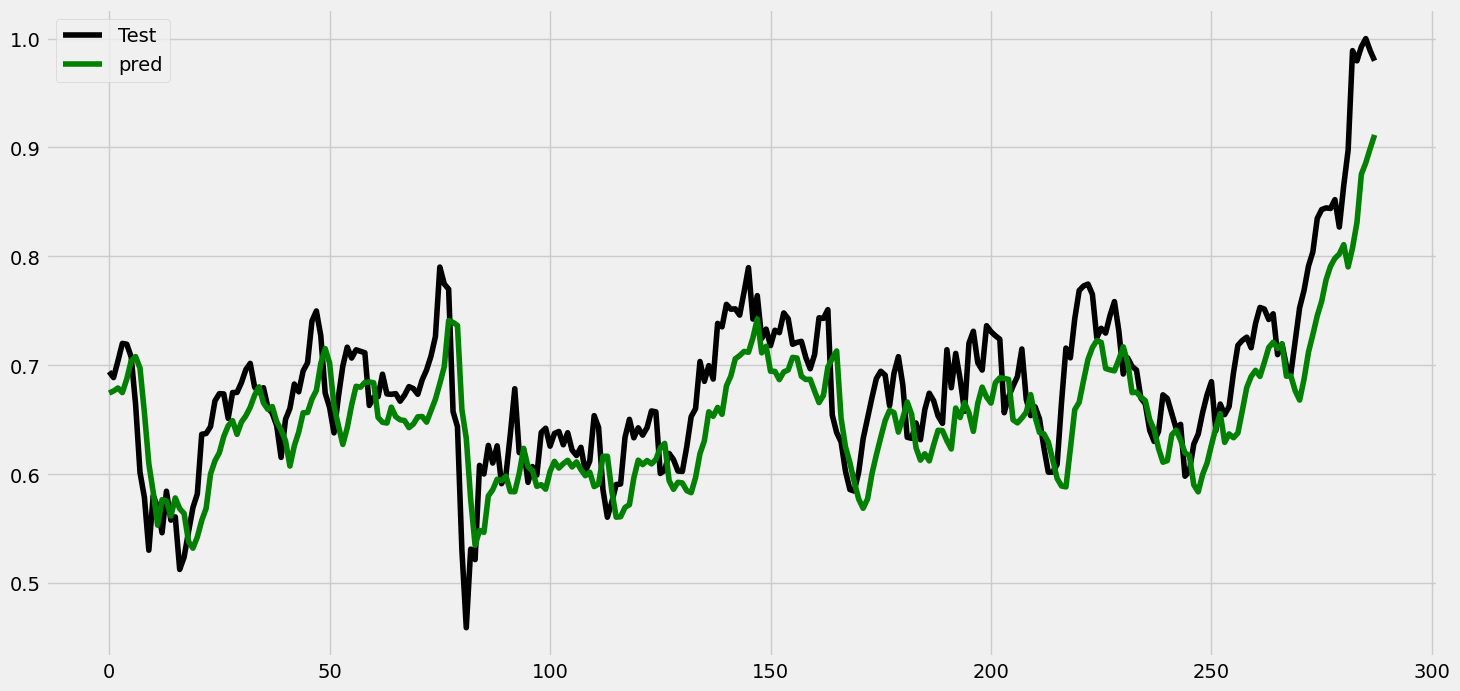

In [152]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [153]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.04126225514476157
Mean Squared Error: 0.002591223500367054
Root Mean Squared Error: 0.050904061727597476


### Nasdaq

In [154]:
nasdaq.dropna(inplace=True)
nasdaq.shape

(1564, 5)

In [155]:
nasdaq.drop(["Volume"], axis = 1, inplace =True)

In [156]:
nasdaq['RSI'] = ta.rsi(nasdaq.Close, length = 14)
nasdaq['EMAF'] = ta.ema(nasdaq.Close, length = 20)
nasdaq['EMAM'] = ta.ema(nasdaq.Close, length = 50)
nasdaq['EMAS'] = ta.ema(nasdaq.Close, length = 100)

nasdaq['Target'] = nasdaq['Close']-nasdaq.Open
nasdaq['Target'] = nasdaq['Target'].shift(-1)

nasdaq['TargetClass'] = [1 if nasdaq.Target[i]>0 else 0 for i in range(len(nasdaq))]

nasdaq['TargetNextClose'] = nasdaq['Close'].shift(-1)

nasdaq.dropna(inplace =True)

In [157]:
sc = MinMaxScaler(feature_range =(0,1))
nasdaq_scaled = sc.fit_transform(nasdaq)
print(nasdaq_scaled)

[[0.00000000e+00 0.00000000e+00 6.77731148e-04 ... 5.25377408e-01
  1.00000000e+00 5.58901126e-04]
 [1.51047795e-03 2.02293559e-03 2.11511699e-03 ... 5.21857106e-01
  1.00000000e+00 2.05886369e-03]
 [3.52489001e-03 3.48804736e-03 4.21127646e-03 ... 5.10412793e-01
  0.00000000e+00 1.79942152e-03]
 ...
 [9.66433061e-01 9.86487047e-01 9.79239565e-01 ... 4.21264705e-01
  0.00000000e+00 9.81206309e-01]
 [9.90709283e-01 9.91286126e-01 9.84640060e-01 ... 6.30485518e-01
  1.00000000e+00 9.95957157e-01]
 [9.74145624e-01 9.94856363e-01 9.77883601e-01 ... 4.95266614e-01
  0.00000000e+00 9.94585295e-01]]


In [158]:
X = []

backcandles = 30
print(nasdaq_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, nasdaq_scaled.shape[0]):
        X[j].append(nasdaq_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(nasdaq_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1464
[[[0.00000000e+00 0.00000000e+00 6.77731148e-04 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [1.51047795e-03 2.02293559e-03 2.11511699e-03 ... 3.05524590e-04
   3.13942595e-04 3.51430779e-04]
  [3.52489001e-03 3.48804736e-03 4.21127646e-03 ... 7.32652239e-04
   6.81356808e-04 7.31739256e-04]
  ...
  [3.93942715e-03 5.26372061e-03 3.70754822e-03 ... 8.13180140e-03
   9.06349627e-03 9.89733957e-03]
  [7.16434061e-03 6.28046334e-03 7.13818131e-03 ... 8.09949182e-03
   9.21260018e-03 1.01566127e-02]
  [7.74575211e-03 6.17496474e-03 7.81862067e-03 ... 8.04600250e-03
   9.34526841e-03 1.04049835e-02]]

 [[1.51047795e-03 2.02293559e-03 2.11511699e-03 ... 3.05524590e-04
   3.13942595e-04 3.51430779e-04]
  [3.52489001e-03 3.48804736e-03 4.21127646e-03 ... 7.32652239e-04
   6.81356808e-04 7.31739256e-04]
  [4.97444557e-03 3.48672862e-03 4.82130220e-03 ... 1.09303501e-03
   1.02298440e-03 1.09831835e-03]
  ...
  [7.16434061e-03 6.28046334e-03 7.13818131e-03 ... 8.09949182e-03
   9.

In [159]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1147
(1147, 30, 8)
(287, 30, 8)
(1147, 1)
(287, 1)
[[0.00518684]
 [0.00504612]
 [0.00833283]
 ...
 [0.45007447]
 [0.45188156]
 [0.45036226]]


In [160]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
69/69 [==============================] - 3s 23ms/step - loss: 6.9002e-04 - val_loss: 1.2739e-04
Epoch 2/30
69/69 [==============================] - 1s 18ms/step - loss: 1.2735e-04 - val_loss: 3.2852e-04
Epoch 3/30
69/69 [==============================] - 1s 18ms/step - loss: 1.2294e-04 - val_loss: 1.3676e-04
Epoch 4/30
69/69 [==============================] - 1s 18ms/step - loss: 1.2472e-04 - val_loss: 1.1055e-04
Epoch 5/30
69/69 [==============================] - 2s 23ms/step - loss: 1.0572e-04 - val_loss: 1.5857e-04
Epoch 6/30
69/69 [==============================] - 2s 32ms/step - loss: 1.0428e-04 - val_loss: 7.1875e-04
Epoch 7/30
69/69 [==============================] - 3s 41ms/step - loss: 1.1337e-04 - val_loss: 1.2647e-04
Epoch 8/30
69/69 [==============================] - 2s 31ms/step - loss: 1.2699e-04 - val_loss: 2.2137e-04
Epoch 9/30
69/69 [==============================] - 3s 37ms/step - loss: 1.1282e-04 - val_loss: 1.8166e-04
Epoch 10/30
69/69 [==================

In [161]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 0s 10ms/step
[0.46013707] [0.45900889]
[0.45881376] [0.4699176]
[0.46595693] [0.45611207]
[0.47747958] [0.46328195]
[0.4637389] [0.46174203]
[0.46832594] [0.46570356]
[0.46901914] [0.44850261]
[0.47309068] [0.42905759]
[0.45601612] [0.42586505]
[0.43362573] [0.40706957]


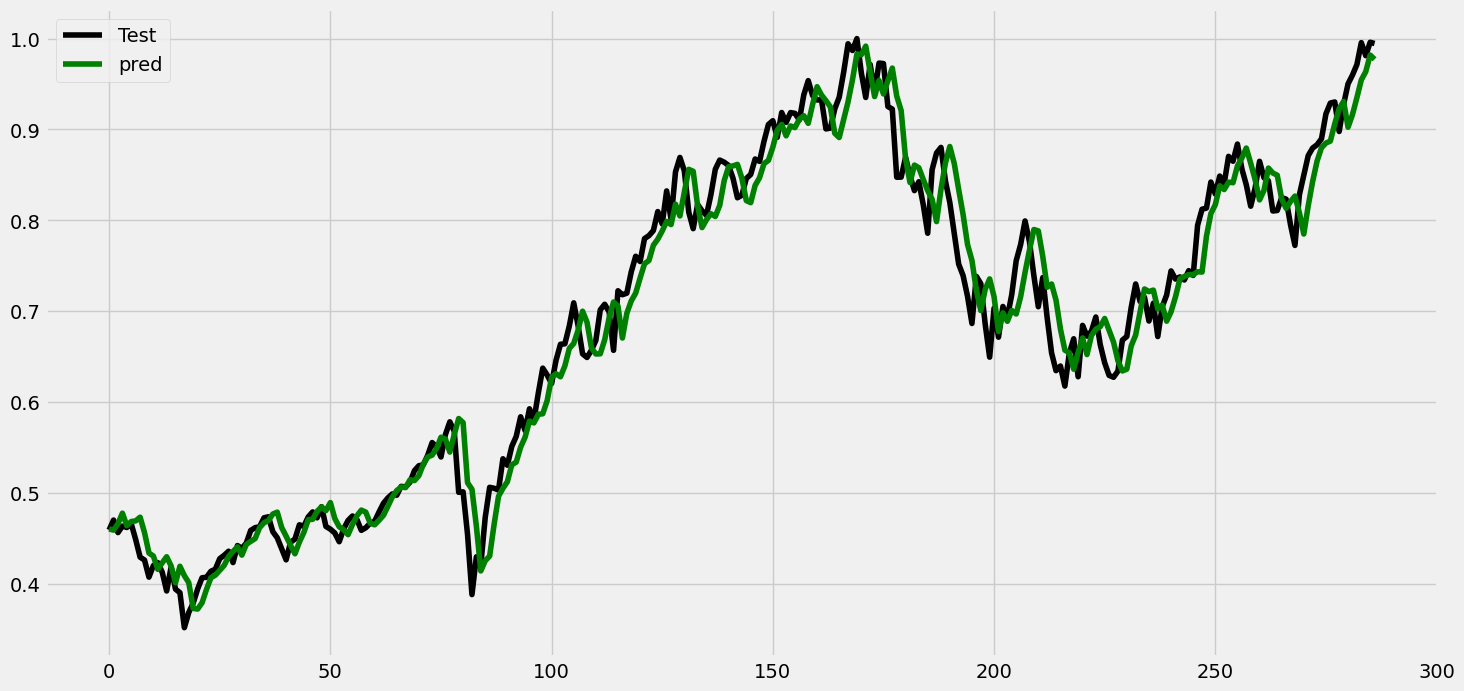

In [162]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [163]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.025805769459720893
Mean Squared Error: 0.0011068293062745942
Root Mean Squared Error: 0.03326904426452004


## Conclusion on LSTM
+ The best RMSE on 6 datasets with LSTM is 0.034 on SP500.
+ The worst RMSE is 0.108 on AMAZON.

# Conclusion of overall project

+ We can remark that both models had highest RMSE in Amazon data frame due to *steppe fall* of Amazon stock prices in 2022, while they did better in more stable data - Models perform better in stable environment
+ If we had more time, future research would be devoted to the development of other models and algorithms to compare the results between them


References of our work:

1.   https://youtu.be/hpfQE0bTeA4?si=i7j8WDzs5-AaD7k8
2.   https://www.kaggle.com/code/akibmir/stock-price-forecasting-ma-arima-sarima-lstm#Model-Fitting
3. https://github.com/das-amlan/Stock-Price-Forecasting/blob/main/Stock_price_forecasting.ipynb
4. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4773344
5. https://www.sciencedirect.com/science/article/pii/S2590291124000615
6. https://neptune.ai/blog/predicting-stock-prices-using-machine-learning
7. https://www.kaggle.com/code/akibmir/stock-price-forecasting-ma-arima-sarima-lstm#Models-used-for-Stock-Price-Forecasting
8. https://youtu.be/lhrCz6t7rmQ?si=4VIoA4CgIAv38yk2
9. https://youtu.be/1O_BenficgE?si=pFIKe4t3AoJ0MaPE

